In [9]:
def highlight_significant_points(ax, xvalues, coefs, lower, marker='o', color='red', s=80, **kwargs):
    """
    Highlights points on the axis where the lower bound of the CI is above zero.
    
    Parameters:
      ax : matplotlib.axes.Axes
          The axis on which to plot.
      xvalues : array-like
          The x-axis positions corresponding to the coefficient estimates.
      coefs : array-like
          The coefficient estimates.
      lower : array-like
          The lower bounds of the confidence intervals.
      marker : str, optional
          The marker style for highlighted points (default is 's' for square).
      color : str, optional
          The color for the highlighted markers (default is 'red').
      s : int, optional
          The size of the highlighted markers.
      **kwargs : additional keyword arguments passed to ax.scatter.
    """
    xvalues = np.array(xvalues)
    coefs = np.array(coefs)
    lower = np.array(lower)
    
    # Create a Boolean mask of points where the lower bound is above zero.
    significant = lower > 0
    if np.any(significant):
        ax.scatter(xvalues[significant],
                   coefs[significant],
                   marker=marker,
                   color=color,
                   s=s,
                   edgecolor='k',
                   linewidth=1.5,
                   zorder=3,
                   **kwargs)

def plot_coefficients(data, shock, spi, temp, stat):
    import os
    import seaborn as sns
           
    shocks = {
        "temp": "Temperature",
        "spi": "Precipitation",
    }

    title_labels = {
        "inutero_1m3m_avg_pos": "1st In-Utero Quarter",
        "inutero_4m6m_avg_pos": "2nd In-Utero Quarter",
        "inutero_6m9m_avg_pos": "3rd In-Utero Quarter",
        "born_1m3m_avg_pos": "1st Born Quarter",
        "born_3m6m_avg_pos": "2nd Born Quarter",
        "born_6m9m_avg_pos": "3rd Born Quarter",
        "born_9m12m_avg_pos": "4th Born Quarter",
        "born_12m15m_avg_pos": "5th Born Quarter",
        "born_15m18m_avg_pos": "6th Born Quarter",
    }
    sign_labels = {
        "_neg": f"Low {shocks[shock]} Shocks",
        "_pos": f"High {shocks[shock]} Shocks",
    }
    fig, axs = plt.subplots(2, 4, figsize=(20, 6))
    xvalues_clean = [0,1,2,3,4]
    for i, key in enumerate(data.keys()):

        if i/2==len(axs.flatten()):
            break
        i_round = i // 2
        pos = int((i/2 - i_round )*2)
        
        plotdata = data[key]
        coefs = np.array(plotdata["coef"][:5])
        lower = np.array(plotdata["lower"][:5])
        upper = np.array(plotdata["upper"][:5])
        
        is_neg = "_neg" in key
        sign = "_neg" if is_neg else "_pos"
        
        if is_neg:
            coefs = coefs*-1
            old_upper = upper
            upper = lower*-1
            lower = old_upper*-1
        yerr = [
            list(np.subtract(coefs, lower)), # 'down' error
            list(np.subtract(upper, coefs))
        ]  # 'up' error
        
        # Get the color from the cycle
        color = sns.color_palette()[0] if is_neg else sns.color_palette()[1]
        
        ax = axs.flatten()[i_round]

        xvalues = plot_tools.distribute_x_values(xvalues_clean, 2, margin=0.25)[pos]
        if i_round != i/2:
            ax.set_title(title_labels[key])
        
        ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=sign_labels[sign], color=color)
        ax.plot(xvalues, coefs, color=color)

        # Now call our helper function to highlight points with a lower CI bound > 0.
        highlight_significant_points(ax, xvalues, coefs, lower, color=color)

        ax.axhline(y=0, color="black", linewidth=1)
        # sns.lineplot(data["inutero_1m3m_avg_pos"]["coef"], ax=ax)
        # sns.despine()
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
        ax.set_xlim(-0.3, 4.6)
        if i<4*2: # Only the first row of plots
            ax.set_ylim(-0.8, 1.5)
        else:
            ax.set_ylim(-0.6, 0.8)
            
    fig.tight_layout()
    plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=2, frameon=False)
    
    outdir = fr"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\{spi} {temp} {stat}"
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(fr"{outdir}\{shock}_coefficients_{spi}_{stat}_{temp}.png", dpi=300, bbox_inches='tight')

In [71]:
def plot_heterogeneity_coefficients(data, shock, spi, temp, stat, sign="_pos"):
    import plot_tools
    import os
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt
            
    # Keep only keys that contain the specified sign
    data = {k: v for k, v in data.items() if sign in k}
    n_heterogeneity = len(data[f"inutero_1m3m_avg{sign}"].keys())

    title_labels = {
        f"inutero_1m3m_avg{sign}": "1st In-Utero Quarter",
        f"inutero_4m6m_avg{sign}": "2nd In-Utero Quarter",
        f"inutero_6m9m_avg{sign}": "3rd In-Utero Quarter",
        f"born_1m3m_avg{sign}": "1st Born Quarter",
        f"born_3m6m_avg{sign}": "2nd Born Quarter",
        f"born_6m9m_avg{sign}": "3rd Born Quarter",
        f"born_9m12m_avg{sign}": "4th Born Quarter",
        f"born_12m15m_avg{sign}": "5th Born Quarter",
        f"born_15m18m_avg{sign}": "6th Born Quarter",
    }
    fig, axs = plt.subplots(2, 4, figsize=(20, 6))
    xvalues_clean = [0,1,2,3,4]
    for i, key in enumerate(data.keys()):
        if "born_15m18m_avg" in key:
            break
        heterogeneity_data = data[key]
        for j, case in enumerate(heterogeneity_data.keys()):

            coefs = np.array(heterogeneity_data[case]["coef"][:5])
            lower = np.array(heterogeneity_data[case]["lower"][:5])
            upper = np.array(heterogeneity_data[case]["upper"][:5])
            
            is_neg = "_neg" in key
            sign = "_neg" if is_neg else "_pos"
            
            if is_neg:
                coefs = coefs*-1
                old_upper = upper
                upper = lower*-1
                lower = old_upper*-1
            yerr = [
                list(np.subtract(coefs, lower)), # 'down' error
                list(np.subtract(upper, coefs))
            ]  # 'up' error
            
            # Get the color from the cycle
            color = sns.color_palette()[j]
            
            ax = axs.flatten()[i]

            xvalues = plot_tools.distribute_x_values(xvalues_clean, n_heterogeneity, margin=0.15)[j]
            
            ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=case, color=color)
            ax.plot(xvalues, coefs, color=color)

            # Now call our helper function to highlight points with a lower CI bound > 0.
            highlight_significant_points(ax, xvalues, coefs, lower, color=color)

        ax.set_title(title_labels[key])
        ax.axhline(y=0, color="black", linewidth=1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
        ax.set_xlim(-0.3, 4.6)

    fig.tight_layout()
    plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=6, frameon=False)

    outdir = fr"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\{spi} {temp} {stat}"
    os.makedirs(outdir, exist_ok=True)
    plt.savefig(fr"{outdir}\heterogeneity - {shock}{sign}_coefficients_{spi}_{stat}_{temp}.png", dpi=300, bbox_inches='tight')

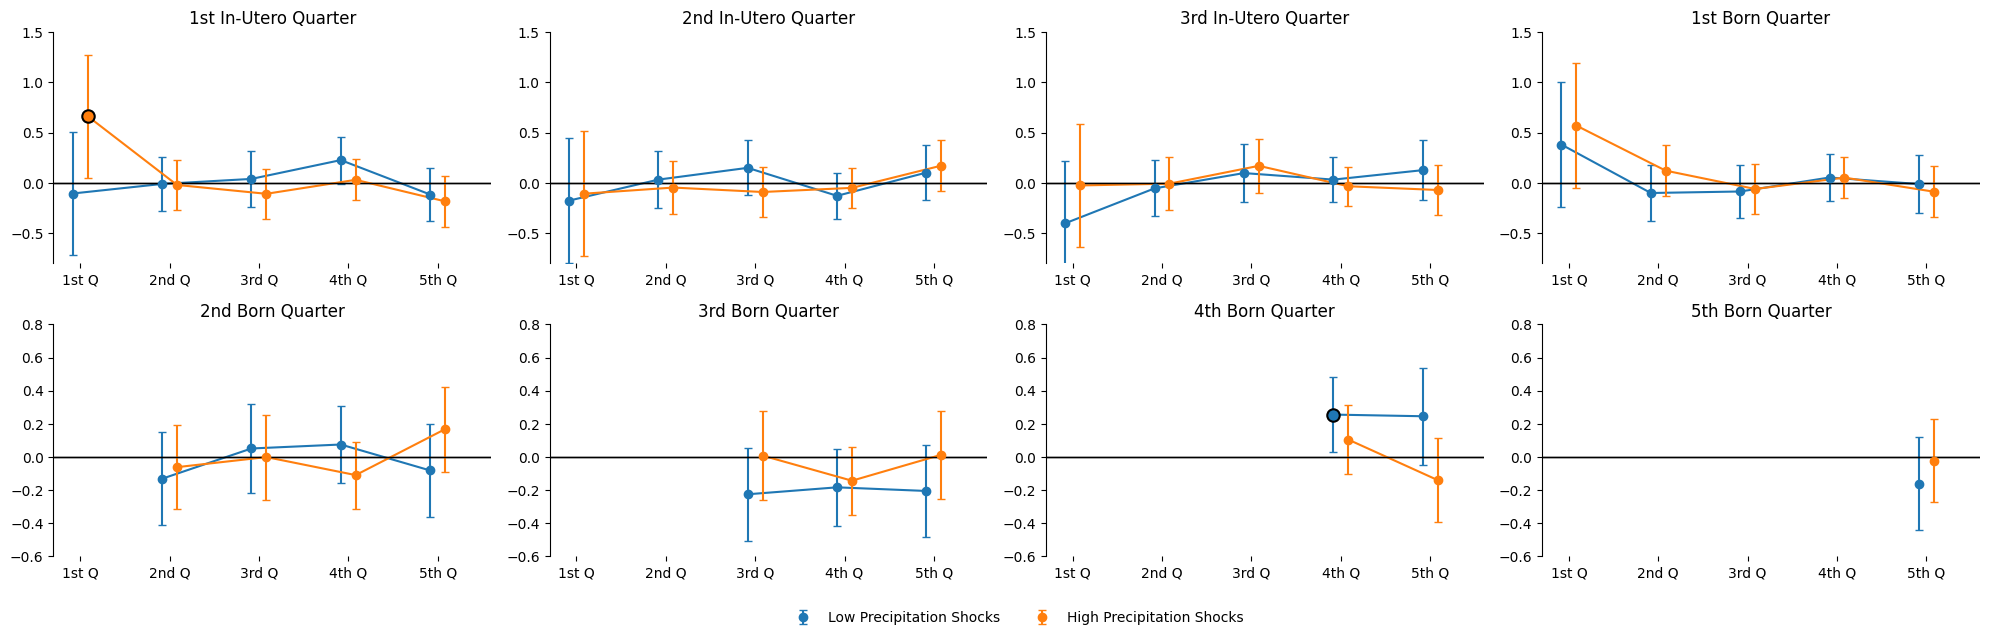

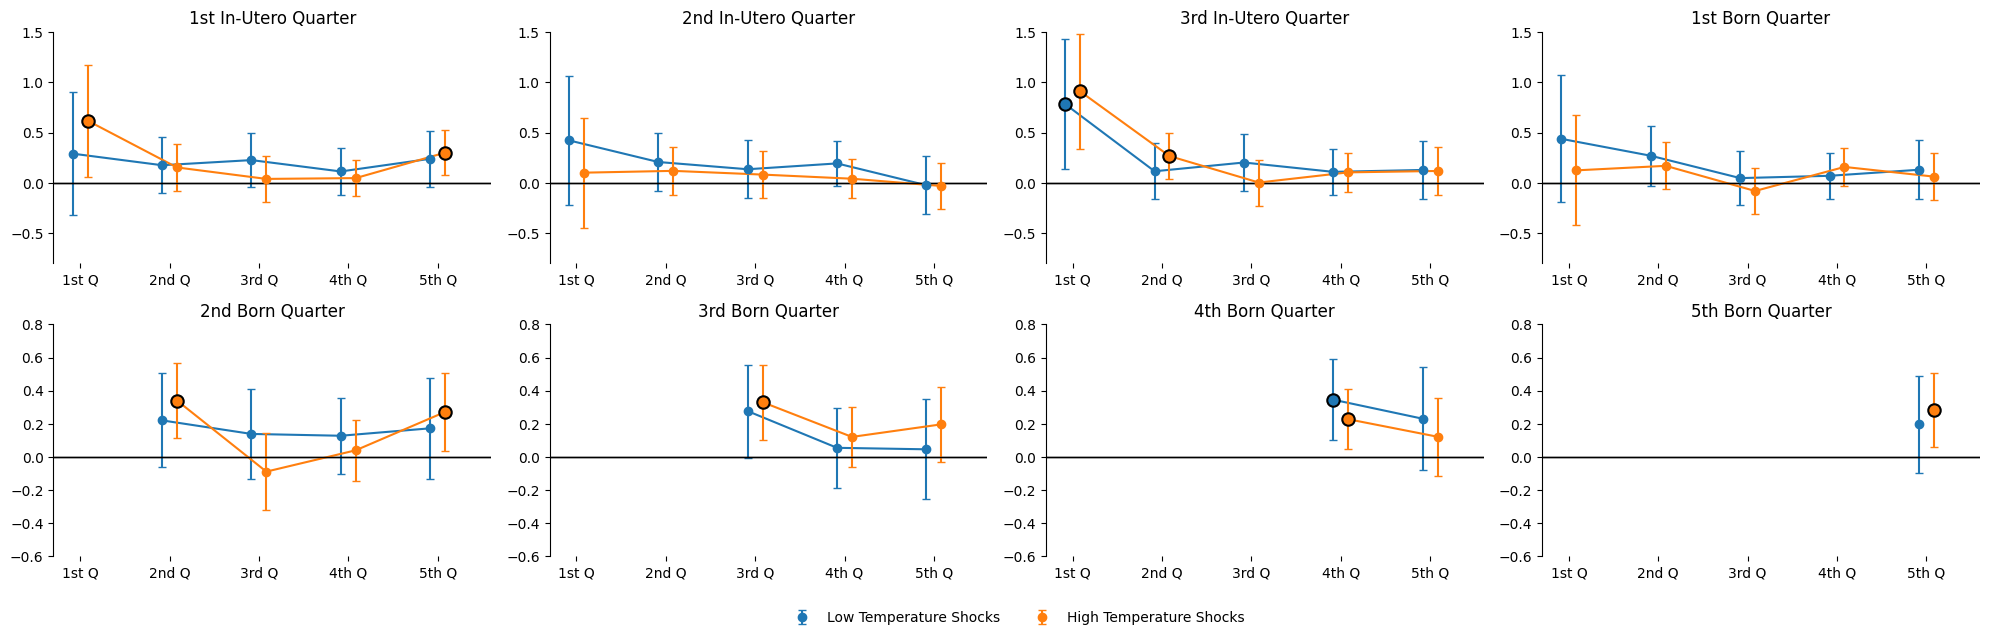

In [66]:
import seaborn as sns
import plot_tools
import matplotlib.pyplot as plt
import numpy as np

spi = "spi1"
temp = "stdm_t"
stat = "avg"

results = plot_tools.extract_coefficients_and_CI_latex(rf"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\linear_dummies_true_{spi}_{stat}_{temp}  standard_fe.tex")

for shock in ["spi", "temp"]:
    data = results[shock]["cell1"]
    plot_coefficients(data, shock, spi, temp, stat)

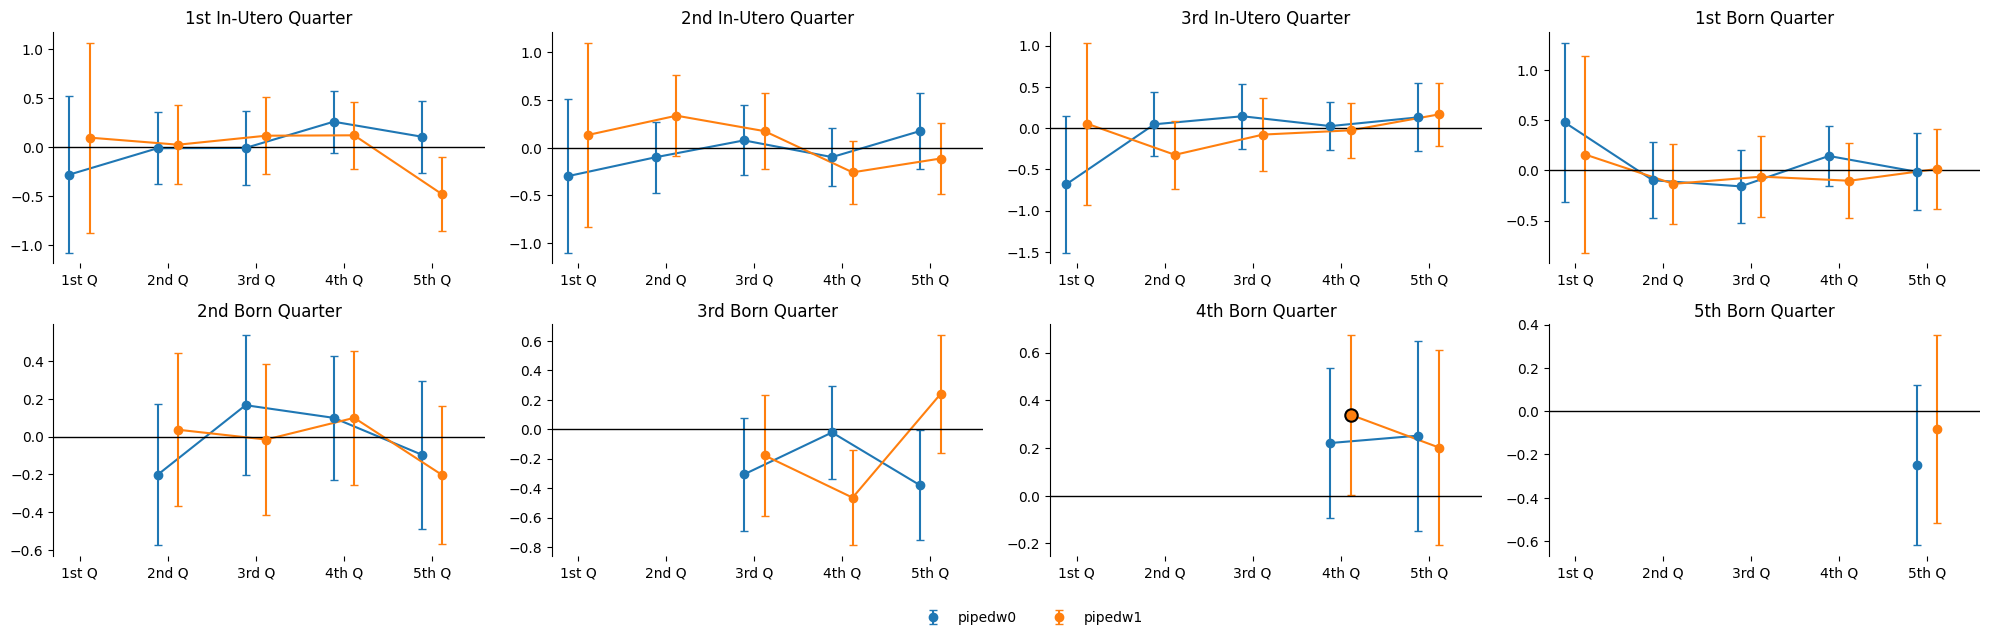

In [86]:
OUTPUTS = r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs"
var = "climate_band_1"
stat = "avg"
temp = "stdm_t"
spi = "spi1"
f_name = f"linear_dummies_true_{spi}_{stat}_{temp}"
var = "pipedw"
shock = "spi"

def extract_coefficients_and_CI_latex_heterogeneity(heterogeneity, shock, spi, temp, stat):
    """
    Extracts coefficients and confidence intervals from a LaTeX file.
    
    Parameters:
      file_path : str
          Path to the LaTeX file containing the regression results.
          
    Returns:
      dict : A dictionary containing the extracted coefficients and confidence intervals.
    """
    files = os.listdir(rf"{OUTPUTS}\heterogeneity\{heterogeneity}")
    files = [f for f in files if f_name in f]
    files = [f for f in files if "standard_fe.tex" in f]
    bands = [f.replace(f"linear_dummies_true_{spi}_{stat}_{temp}  - ", "").replace(" standard_fe.tex", "") for f in files] 

    plotdata = {}
    for i, band in enumerate(bands):

        file_path = rf"{OUTPUTS}\heterogeneity\\{heterogeneity}\{files[i]}"
        n = plot_tools.extract_sample_size(file_path)

        if n < 100_000:
            continue
        outdata = plot_tools.extract_coefficients_and_CI_latex(file_path)

        # Gather all the keys:
        keys = list(outdata[shock]["cell1"].keys())

        for key in keys:
            if key not in plotdata:
                plotdata[key] = {}
            plotdata[key][band] = outdata[shock]["cell1"][key]
    
    return plotdata


plotdata = extract_coefficients_and_CI_latex_heterogeneity(var, shock, spi, temp, stat)
# plotdata["inutero_1m3m_avg_neg"]
plot_heterogeneity_coefficients(plotdata, shock, spi, temp, stat, sign="_neg")

In [34]:
a  = {"rock":None}

# check if rock is key of a
"rock" in a.keys()

True

In [13]:
results = plot_tools.extract_coefficients_and_CI_latex(rf"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\heterogeneity\linear_dummies_true_{spi}_{stat}_{temp}  standard_fe.tex")
results

{'spi': {'cell1': {'inutero_1m3m_avg_neg': {'coef': [0.105,
     0.01,
     -0.04,
     -0.227,
     0.115,
     -0.103,
     -0.077,
     -0.085],
    'se': [0.301, 0.132, 0.137, 0.114, 0.129, 0.064, 0.074, 0.041],
    'lower': [-0.5096419999999999,
     -0.259544,
     -0.319754,
     -0.459788,
     -0.148418,
     -0.233688,
     -0.22810799999999998,
     -0.16872199999999998],
    'upper': [0.7196419999999999,
     0.279544,
     0.239754,
     0.005787999999999988,
     0.378418,
     0.027688000000000004,
     0.074108,
     -0.0012780000000000152]},
   'inutero_1m3m_avg_pos': {'coef': [0.664,
     -0.02,
     -0.108,
     0.031,
     -0.183,
     0.04,
     0.024,
     0.04],
    'se': [0.299, 0.122, 0.121, 0.099, 0.125, 0.06, 0.065, 0.037],
    'lower': [0.0534420000000001,
     -0.269124,
     -0.35508199999999995,
     -0.171158,
     -0.43825,
     -0.08251999999999998,
     -0.10873,
     -0.035553999999999995],
    'upper': [1.2745579999999999,
     0.229124,
     0.1390

In [ ]:
import os
import seaborn as sns

is_list = isinstance(data, list)

if not is_list:
    data = [data]
    
shocks = {
    "temp": "Temperature",
    "spi": "Precipitation",
}

title_labels = {
    "inutero_1m3m_avg_pos": "1st In-Utero Quarter",
    "inutero_4m6m_avg_pos": "2nd In-Utero Quarter",
    "inutero_6m9m_avg_pos": "3rd In-Utero Quarter",
    "born_1m3m_avg_pos": "1st Born Quarter",
    "born_3m6m_avg_pos": "2nd Born Quarter",
    "born_6m9m_avg_pos": "3rd Born Quarter",
    "born_9m12m_avg_pos": "4th Born Quarter",
    "born_12m15m_avg_pos": "5th Born Quarter",
    "born_15m18m_avg_pos": "6th Born Quarter",
}
sign_labels = {
    "_neg": f"Low {shocks[shock]} Shocks",
    "_pos": f"High {shocks[shock]} Shocks",
}
fig, axs = plt.subplots(2, 4, figsize=(20, 6))
xvalues_clean = [0,1,2,3,4]
for data in datasets:
    for i, key in enumerate(data.keys()):

        if i/2==len(axs.flatten()):
            break
        i_round = i // 2
        pos = int((i/2 - i_round )*2)
        
        plotdata = data[key]
        coefs = np.array(plotdata["coef"][:5])
        lower = np.array(plotdata["lower"][:5])
        upper = np.array(plotdata["upper"][:5])
        
        is_neg = "_neg" in key
        sign = "_neg" if is_neg else "_pos"
        
        if is_neg:
            coefs = coefs*-1
            old_upper = upper
            upper = lower*-1
            lower = old_upper*-1
        yerr = [
            list(np.subtract(coefs, lower)), # 'down' error
            list(np.subtract(upper, coefs))
        ]  # 'up' error
        
        # Get the color from the cycle
        color = sns.color_palette()[0] if is_neg else sns.color_palette()[1]
        
        ax = axs.flatten()[i_round]

        xvalues = plot_tools.distribute_x_values(xvalues_clean, 2, margin=0.25)[pos]
        if i_round != i/2:
            ax.set_title(title_labels[key])
        
        ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=sign_labels[sign], color=color)
        ax.plot(xvalues, coefs, color=color)

        # Now call our helper function to highlight points with a lower CI bound > 0.
        highlight_significant_points(ax, xvalues, coefs, lower, color=color)

        ax.axhline(y=0, color="black", linewidth=1)
        # sns.lineplot(data["inutero_1m3m_avg_pos"]["coef"], ax=ax)
        # sns.despine()
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
        ax.set_xlim(-0.3, 4.6)
        # if i<4*2: # Only the first row of plots
        #     ax.set_ylim(-0.8, 1.5)
        # else:
        #     ax.set_ylim(-0.6, 0.8)
        
fig.tight_layout()
# plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=2, frameon=False)

# outdir = fr"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\{spi} {temp} {stat}"
# os.makedirs(outdir, exist_ok=True)
# plt.savefig(fr"{outdir}\{shock}_coefficients_{spi}_{stat}_{temp}.png", dpi=300, bbox_inches='tight')

In [5]:
results

{'spi': {'cell1': {'inutero_1m3m_avg_neg': {'coef': [0.105,
     0.01,
     -0.04,
     -0.227,
     0.115,
     -0.103,
     -0.077,
     -0.085],
    'se': [0.301, 0.132, 0.137, 0.114, 0.129, 0.064, 0.074, 0.041],
    'lower': [-0.5096419999999999,
     -0.259544,
     -0.319754,
     -0.459788,
     -0.148418,
     -0.233688,
     -0.22810799999999998,
     -0.16872199999999998],
    'upper': [0.7196419999999999,
     0.279544,
     0.239754,
     0.005787999999999988,
     0.378418,
     0.027688000000000004,
     0.074108,
     -0.0012780000000000152]},
   'inutero_1m3m_avg_pos': {'coef': [0.664,
     -0.02,
     -0.108,
     0.031,
     -0.183,
     0.04,
     0.024,
     0.04],
    'se': [0.299, 0.122, 0.121, 0.099, 0.125, 0.06, 0.065, 0.037],
    'lower': [0.0534420000000001,
     -0.269124,
     -0.35508199999999995,
     -0.171158,
     -0.43825,
     -0.08251999999999998,
     -0.10873,
     -0.035553999999999995],
    'upper': [1.2745579999999999,
     0.229124,
     0.1390

In [ ]:
import seaborn as sns
import plot_tools
import matplotlib.pyplot as plt
import numpy as np

spi, temp = plot_tools.extract_coefficients_and_CI_latex(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\linear_dummies_true_spi1_avg_stdm_t  standard_fe.tex")

fig, axs = plt.subplots(2, 4, figsize=(20, 6))

data = temp["cell1"]
sign_labels = {
    "_neg": "Low Temperature Shocks",
    "_pos": "High Temperature Shocks",
}
title_labels = {
    "inutero_1m3m_avg_pos": "1st In-Utero Quarter",
    "inutero_4m6m_avg_pos": "2nd In-Utero Quarter",
    "inutero_6m9m_avg_pos": "3rd In-Utero Quarter",
    "born_1m3m_avg_pos": "1st Born Quarter",
    "born_3m6m_avg_pos": "2nd Born Quarter",
    "born_6m9m_avg_pos": "3rd Born Quarter",
    "born_9m12m_avg_pos": "4th Born Quarter",
    "born_12m15m_avg_pos": "5th Born Quarter",
    "born_15m18m_avg_pos": "6th Born Quarter",
}

xvalues_clean = [0,1,2,3,4]
for i, key in enumerate(data.keys()):

    if i/2==len(axs.flatten()):
        break
    i_round = i // 2
    pos = int((i/2 - i_round )*2)
    
    plotdata = data[key]
    coefs = np.array(plotdata["coef"][:5])
    lower = np.array(plotdata["lower"][:5])
    upper = np.array(plotdata["upper"][:5])
    
    is_neg = "_neg" in key
    sign = "_neg" if is_neg else "_pos"
    
    if is_neg:
        coefs = coefs*-1
        old_upper = upper
        upper = lower*-1
        lower = old_upper*-1
    yerr = [
        list(np.subtract(coefs, lower)), # 'down' error
        list(np.subtract(upper, coefs))
    ]  # 'up' error
    
    # Get the color from the cycle
    color = sns.color_palette()[0] if is_neg else sns.color_palette()[1]
    
    ax = axs.flatten()[i_round]

    xvalues = plot_tools.distribute_x_values(xvalues_clean, 2, margin=0.25)[pos]
    if i_round != i/2:
        ax.set_title(title_labels[key])
    
    ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=sign_labels[sign], color=color)
    ax.plot(xvalues, coefs, color=color)

    # Now call our helper function to highlight points with a lower CI bound > 0.
    highlight_significant_points(ax, xvalues, coefs, lower, color=color)

    ax.axhline(y=0, color="black", linewidth=1)
    # sns.lineplot(data["inutero_1m3m_avg_pos"]["coef"], ax=ax)
    # sns.despine()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
    ax.set_xlim(-0.3, 4.6)
    if i<4*2: # Only the first row of plots
        ax.set_ylim(-0.5, 1.5)
    else:
        ax.set_ylim(-0.4, 0.8)
        
fig.tight_layout()
plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=2, frameon=False)

In [24]:
xvalues

[[-0.08333333333333334,
  0.9166666666666666,
  1.9166666666666667,
  2.9166666666666665,
  3.9166666666666665],
 [0.08333333333333331,
  1.0833333333333333,
  2.0833333333333335,
  3.0833333333333335,
  4.083333333333333]]

In [23]:
xvalues

[[-0.08333333333333334,
  0.9166666666666666,
  1.9166666666666667,
  2.9166666666666665,
  3.9166666666666665],
 [0.08333333333333331,
  1.0833333333333333,
  2.0833333333333335,
  3.0833333333333335,
  4.083333333333333]]

In [158]:
axs.flatten()

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

In [147]:
7 // 2

3

In [131]:
axs.flatten()[3]

<Axes: >

In [86]:
yerr

[[-0.6218004000000001, -0.2828256, -0.2765868, -0.23707440000000002],
 [-0.6218004, -0.2828256, -0.2765868, -0.23707440000000002]]

In [69]:
yerr

[[0.6218004000000001, 0.2828256, 0.2765868, 0.23707440000000002],
 [0.6218004, 0.2828256, 0.2765868, 0.23707440000000002]]

In [44]:
xvalues, coefs, yerr

([0, 1, 2, 3],
 array([  nan,   nan,   nan, 0.227]),
 [[nan, nan, nan, 0.1850844], [nan, nan, nan, 0.1850844]])

In [41]:
data

{'inutero_1m3m_avg_neg': {'coef': [-0.291,
   -0.176,
   -0.227,
   -0.114,
   -0.24,
   0.043,
   -0.088,
   0.001],
  'se': [0.299, 0.136, 0.133, 0.114, 0.135, 0.066, 0.075, 0.037],
  'lower': [-0.9128004000000001,
   -0.4588256,
   -0.5035868,
   -0.3510744,
   -0.520746,
   -0.0942536,
   -0.24397,
   -0.0759452],
  'upper': [0.33080040000000005,
   0.10682560000000002,
   0.049586800000000014,
   0.12307440000000001,
   0.04074600000000006,
   0.1802536,
   0.06797,
   0.0779452]},
 'inutero_1m3m_avg_pos': {'coef': [0.619,
   0.154,
   0.04,
   0.048,
   0.301,
   -0.053,
   0.074,
   -0.051],
  'se': [0.272, 0.115, 0.11, 0.089, 0.108, 0.053, 0.059, 0.03],
  'lower': [0.053348799999999974,
   -0.08515400000000004,
   -0.188756,
   -0.1370844,
   0.07640319999999998,
   -0.1632188,
   -0.0486964,
   -0.11338799999999999],
  'upper': [1.1846512,
   0.393154,
   0.268756,
   0.23308440000000002,
   0.5255968,
   0.05721880000000001,
   0.1966964,
   0.011388000000000002]},
 'inutero_

In [35]:
data[key]["coef"

[0.619, 0.154, 0.04, 0.048, 0.301, -0.053, 0.074, -0.051]

In [18]:
keys

['inutero_1m3m_avg_pos',
 'inutero_4m6m_avg_pos',
 'inutero_6m9m_avg_pos',
 'born_1m3m_avg_pos',
 'born_3m6m_avg_pos',
 'born_6m9m_avg_pos',
 'born_9m12m_avg_pos',
 'born_12m15m_avg_pos',
 'born_15m18m_avg_pos',
 'born_18m21m_avg_pos',
 'born_21m24m_avg_pos']

In [15]:
outdata[1]["cell1"]

{'inutero_1m3m_avg_neg': {'coef': [-0.291,
   -0.176,
   -0.227,
   -0.114,
   -0.24,
   0.043,
   -0.088,
   0.001],
  'se': [0.299, 0.136, 0.133, 0.114, 0.135, 0.066, 0.075, 0.037],
  'lower': [-0.9128004000000001,
   -0.4588256,
   -0.5035868,
   -0.3510744,
   -0.520746,
   -0.0942536,
   -0.24397,
   -0.0759452],
  'upper': [0.33080040000000005,
   0.10682560000000002,
   0.049586800000000014,
   0.12307440000000001,
   0.04074600000000006,
   0.1802536,
   0.06797,
   0.0779452]},
 'inutero_1m3m_avg_pos': {'coef': [0.619,
   0.154,
   0.04,
   0.048,
   0.301,
   -0.053,
   0.074,
   -0.051],
  'se': [0.272, 0.115, 0.11, 0.089, 0.108, 0.053, 0.059, 0.03],
  'lower': [0.053348799999999974,
   -0.08515400000000004,
   -0.188756,
   -0.1370844,
   0.07640319999999998,
   -0.1632188,
   -0.0486964,
   -0.11338799999999999],
  'upper': [1.1846512,
   0.393154,
   0.268756,
   0.23308440000000002,
   0.5255968,
   0.05721880000000001,
   0.1966964,
   0.011388000000000002]},
 'inutero_

In [21]:
valid_timeframes

['inutero_1m3m',
 'inutero_4m6m',
 'inutero_6m9m',
 'born_1m3m',
 'born_3m6m',
 'born_6m9m',
 'born_9m12m',
 'born_12m15m',
 'born_15m18m',
 'born_18m21m',
 'born_21m24m']

In [20]:
data[key]["coef"]

[0.664, -0.02, -0.108, 0.031, -0.183, 0.04, 0.024, 0.04]

In [18]:
#make tuples zipping the two lists



[(0.042199600000000004, 1.2858004),
 (-0.27371120000000004, 0.23371120000000004),
 (-0.3596316, 0.14363160000000003),
 (-0.17488040000000002, 0.23688040000000002),
 (-0.44295, 0.07695000000000002),
 (-0.08477599999999999, 0.164776),
 (-0.11117400000000002, 0.159174),
 (-0.036945200000000004, 0.1169452)]

In [39]:
outdata = plot_tools.extract_coefficients_and_CI_latex(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\linear_dummies_true_spi1_avg_stdm_t  standard_fe.tex")

values_sfe = (outdata["temp_pos"]["coefs"] + outdata["spi_pos"]["coefs"], outdata["temp_neg"]["coefs"] + outdata["spi_neg"]["coefs"])
lower_sfe  = (outdata["temp_pos"]["lower"] + outdata["spi_pos"]["lower"], outdata["temp_neg"]["lower"] + outdata["spi_neg"]["lower"])
upper_sfe  = (outdata["temp_pos"]["upper"] + outdata["spi_pos"]["upper"], outdata["temp_neg"]["upper"] + outdata["spi_neg"]["upper"])

plot_tools.plot_regression_coefficients(
    values_sfe, 
    upper_sfe,
    lower_sfe,
    margin=0.14,
    colors=["#ff5100", "#3e9fe1"], 
    labels=["High temperature shocks","Low temperature shocks"], 
    plot="only_temp", 
    outpath=rf"{OUT_FIGS}\coefplot_temp.png"
)


{'inutero_1m3m_avg_neg': {'coef': [0.105,
   0.01,
   -0.04,
   -0.227,
   0.115,
   -0.103,
   -0.077,
   -0.085],
  'se': [0.301, 0.132, 0.137, 0.114, 0.129, 0.064, 0.074, 0.041],
  'lower': [-0.5209596000000001,
   -0.2645072,
   -0.3249052,
   -0.4640744,
   -0.15326840000000003,
   -0.23609439999999998,
   -0.2308904,
   -0.17026360000000001],
  'upper': [0.7309596,
   0.2845072,
   0.24490520000000002,
   0.010074400000000011,
   0.3832684,
   0.030094400000000007,
   0.07689040000000001,
   0.0002636000000000027]},
 'inutero_1m3m_avg_pos': {'coef': [0.664,
   -0.02,
   -0.108,
   0.031,
   -0.183,
   0.04,
   0.024,
   0.04],
  'se': [0.299, 0.122, 0.121, 0.099, 0.125, 0.06, 0.065, 0.037],
  'lower': [0.042199600000000004,
   -0.27371120000000004,
   -0.3596316,
   -0.17488040000000002,
   -0.44295,
   -0.08477599999999999,
   -0.11117400000000002,
   -0.036945200000000004],
  'upper': [1.2858004,
   0.23371120000000004,
   0.14363160000000003,
   0.23688040000000002,
   0.07695

In [7]:
def remove_words_from_string(long_string, words):
    found_words = [w for w in words if w in long_string]
    for word in words:
        long_string = long_string.replace(word, "")
    return long_string.strip(), found_words

remove_words_from_string(first_token, valid_spis)


('stdm_t_born_21m24m_avg_pos', [])

In [ ]:
# Step 1. Remove LaTeX formatting lines (e.g. comments and rules)
lines = latex_table.splitlines()
data_lines = []
for line in lines:
    line = line.strip()
    # Skip empty lines and lines that are only LaTeX rules (e.g. lines starting with % or \toprule, \midrule, etc.)
    if not line or line.startswith('%') or re.match(r'\\(toprule|midrule|bottomrule|cmidrule)', line):
        continue
    data_lines.append(line)

# Step 2. Join the lines and split by the LaTeX row separator (\\)
joined = "\n".join(data_lines)
# Split on double backslashes (which mark the end of a row)
raw_rows = re.split(r'\\\\', joined)
# Remove any empty rows and strip extra whitespace
rows = [row.strip() for row in raw_rows if row.strip()]

# Step 3. Split each row into cells by '&'
data = []
for row in rows:
    # Split on '&' and strip whitespace
    cells = [cell.strip() for cell in row.split('&')]
    data.append(cells)

# Step 4. Assume the first two rows are header rows
header_row1 = data[0]
header_row2 = data[1]
data_body = data[2:]

# Combine the two header rows into one list of column names.
# The first column is the variable name.
col_names = ['Variable']
for h1, h2 in zip(header_row1[1:], header_row2[1:]):
    # For h1, extract the content inside the last {} if it uses \multicolumn
    m = re.search(r'\{([^{}]+)\}\s*$', h1)
    if m:
        h1_clean = m.group(1)
    else:
        h1_clean = h1
    # Remove extra spaces and keep the second header row as is.
    h2_clean = h2.strip()
    # Combine to form a column name (e.g., "child_agedeath_1m3m (1)")
    col_names.append(f"{h1_clean} {h2_clean}")

# Step 5. Create the DataFrame using the data body.
df = pd.DataFrame(data_body, columns=col_names)

# (Optional) If you want to treat rows with parentheses as standard errors, you might add a new column indicator.
# For example, you could add a column 'RowType' based on whether the "Variable" cell is empty (indicating standard error) or not.

# Quick check:
print(df.head(6))

In [1]:
import pandas as pd
cols = [
    "stdm_t_inutero_avg",
    # "absdif_t_inutero_avg",
    "absdifm_t_inutero_avg",
    "spi1_inutero_avg",
    "stdm_t_30d_avg",
    "absdifm_t_30d_avg",
    # "absdif_t_30d_avg",
    "spi1_30d_avg",
    "stdm_t_2m12m_avg",
    # "absdif_t_2m12m_avg",
    "absdifm_t_2m12m_avg",
    "spi1_2m12m_avg",
]
df = pd.read_csv(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out\DHSBirthsGlobal&ClimateShocks_v9.csv", usecols=cols)#, nrows=1000)
df

absdifm_t_inutero_avg  absdifm_t_30d_avg  absdifm_t_2m12m_avg  \
0                    -0.403748          -1.543702            -0.330307   
1                    -0.309900           1.133270             0.559769   
2                    -0.362877           0.246470            -0.354058   
3                    -0.856421          -0.635496             0.000411   
4                     0.821236           0.356678            -0.024038   
...                        ...                ...                  ...   
4641502              -0.248382           1.004227             0.046328   
4641503              -1.178841          -0.565273            -0.236372   
4641504              -1.178841          -0.565273            -0.236372   
4641505              -0.132657          -0.278461             0.670801   
4641506              -0.132657          -0.278461             0.670801   

         spi1_inutero_avg  spi1_30d_avg  spi1_2m12m_avg  stdm_t_inutero_avg  \
0                0.305547      0.734101       -0.545653           -0.354472   
1               -0.262008     -0.396382        0.007454           -0.167371   
2               -0.238486      1.003365        0.051291           -0.202820   
3                0.532852      1.241058       -0.270728           -0.607144   
4               -0.048810     -0.237758       -0.130944            0.573119   
...                   ...           ...             ...                 ...   
4641502         -0.498985     -0.396264       -0.040128           -0.263054   
4641503          0.146751     -0.367551       -0.405842           -0.929817   
4641504          0.146751     -0.367551       -0.405842           -0.929817   
4641505         -0.323780      0.489331       -0.888611           -0.146580   
4641506         -0.323780      0.489331       -0.888611           -0.146580   

         stdm_t_30d_avg  stdm_t_2m12m_avg  
0             -1.253439         -0.323921  
1              0.880528          0.357223  
2              0.227299         -0.223873  
3             -0.599255          0.003155  
4              0.400386         -0.020577  
...                 ...               ...  
4641502        0.810320         -0.008368  
4641503       -0.501798         -0.162374  
4641504       -0.501798         -0.162374  
4641505       -0.158416          0.620089  
4641506       -0.158416          0.620089  

[4641507 rows x 9 columns]

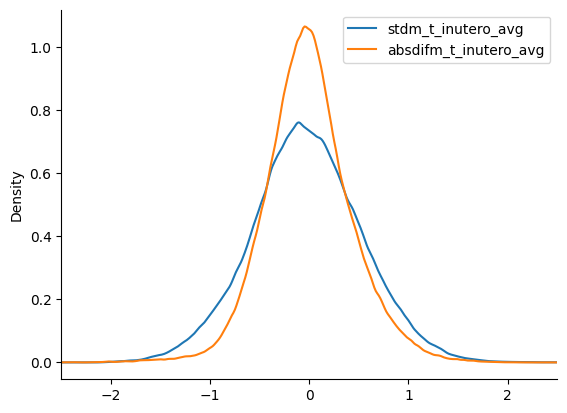

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = df[[
    "stdm_t_inutero_avg",
    "absdifm_t_inutero_avg",
]].rename(
    {
        "stdm_t_inutero_avg": "Standardized Temperature",
        "absdifm_t_inutero_avg": "Absolute Deviation Temperature",   
    }
    ).plot(kind="kde")
ax.set_xlim(-2.5, 2.5)
sns.despine()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = df[[
    "stdm_t_inutero_avg",
    "absdifm_t_inutero_avg",
]].rename(
    {
        "stdm_t_inutero_avg": "Standardized Temperature",
        "absdifm_t_inutero_avg": "Absolute Deviation Temperature",   
    }
    ).plot(kind="kde")
ax.set_xlim(-2.5, 2.5)
sns.despine()

ID_R                object
ID_CB               object
chb_year             int64
chb_month            int64
child_fem            int64
                    ...   
mother_ageb_cub    float64
mother_eduy_squ      int64
mother_eduy_cub      int64
birth_order          int64
chb_year_sq          int64
Length: 1145, dtype: object

In [32]:
int_dtypes = {k:v for k, v in df.dtypes.items() if v == "int64"}

In [57]:
def plot_spline_coefficients(
        data, 
        shock,
        spi, 
        temp, 
        stat,
        margin=0.2,
        colors=["#ff5100", "#3e9fe1"], 
        labels=["High temperature shocks","Low temperature shocks"],
        outpath=None,
    ):
    
    import os
    import seaborn as sns

    title_labels = {
        "inutero_1m3m": "1st In-Utero Quarter",
        "inutero_4m6m": "2nd In-Utero Quarter",
        "inutero_6m9m": "3rd In-Utero Quarter",
        "born_1m3m": "1st Born Quarter",
        "born_3m6m": "2nd Born Quarter",
        "born_6m9m": "3rd Born Quarter",
        "born_9m12m": "4th Born Quarter",
        "born_12m15m": "5th Born Quarter",
        "born_15m18m": "6th Born Quarter",
    }

    data = data[shock]["cell1"]

    fig, axs = plt.subplots(2, 4, figsize=(20, 6))

    xvalues_clean = [0,1,2,3,4]
    line_values = []
    for i, key in enumerate(data.keys()):
        if i/4==len(axs.flatten()):
            break
        i_round = i // 4
        pos = int((i/4 - i_round )*4)
        
        plotdata = data[key]

        coefs = np.array(plotdata["coef"][:5])
        lower = np.array(plotdata["lower"][:5])
        upper = np.array(plotdata["upper"][:5])
        
        is_neg = ("ltm1" or "bt0m1") in key
        if is_neg:
            coefs = coefs*-1
            old_upper = upper
            upper = lower*-1
            lower = old_upper*-1
        yerr = [
            list(np.subtract(coefs, lower)), # 'down' error
            list(np.subtract(upper, coefs))
        ]  # 'up' error
        
        # Get the color from the cycle
        color = colors[pos]
        label = labels[pos]
        
        ax = axs.flatten()[i_round]

        xvalues = plot_tools.distribute_x_values(xvalues_clean, 4, margin=margin)[pos]
        if pos == 3:
            ax.set_title(title_labels[key.split(f"_{stat}")[0]])
        
        ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=label, color=color)

        # Now call our helper function to highlight points with a lower CI bound > 0.
        plot_tools.highlight_significant_points(ax, xvalues, coefs, lower, color=color)

        ax.axhline(y=0, color="black", linewidth=1)
        # sns.lineplot(data["inutero_1m3m_avg_pos"]["coef"], ax=ax)
        # sns.despine()
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
        ax.set_xlim(-0.3, 4.6)
        line_values += [coefs] 
            
    fig.tight_layout()
    plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=2, frameon=False)

    os.makedirs(outpath, exist_ok=True)
    filename = fr"{outpath}\{shock}_spline_coefficients_{spi}_{stat}_{temp}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print("Se creó la figura ", filename)

    return

Se creó la figura  D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\spi1 stdm_t avg\spi_spline_coefficients_spi1_avg_stdm_t.png
Se creó la figura  D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\spi1 stdm_t avg\temp_spline_coefficients_spi1_avg_stdm_t.png


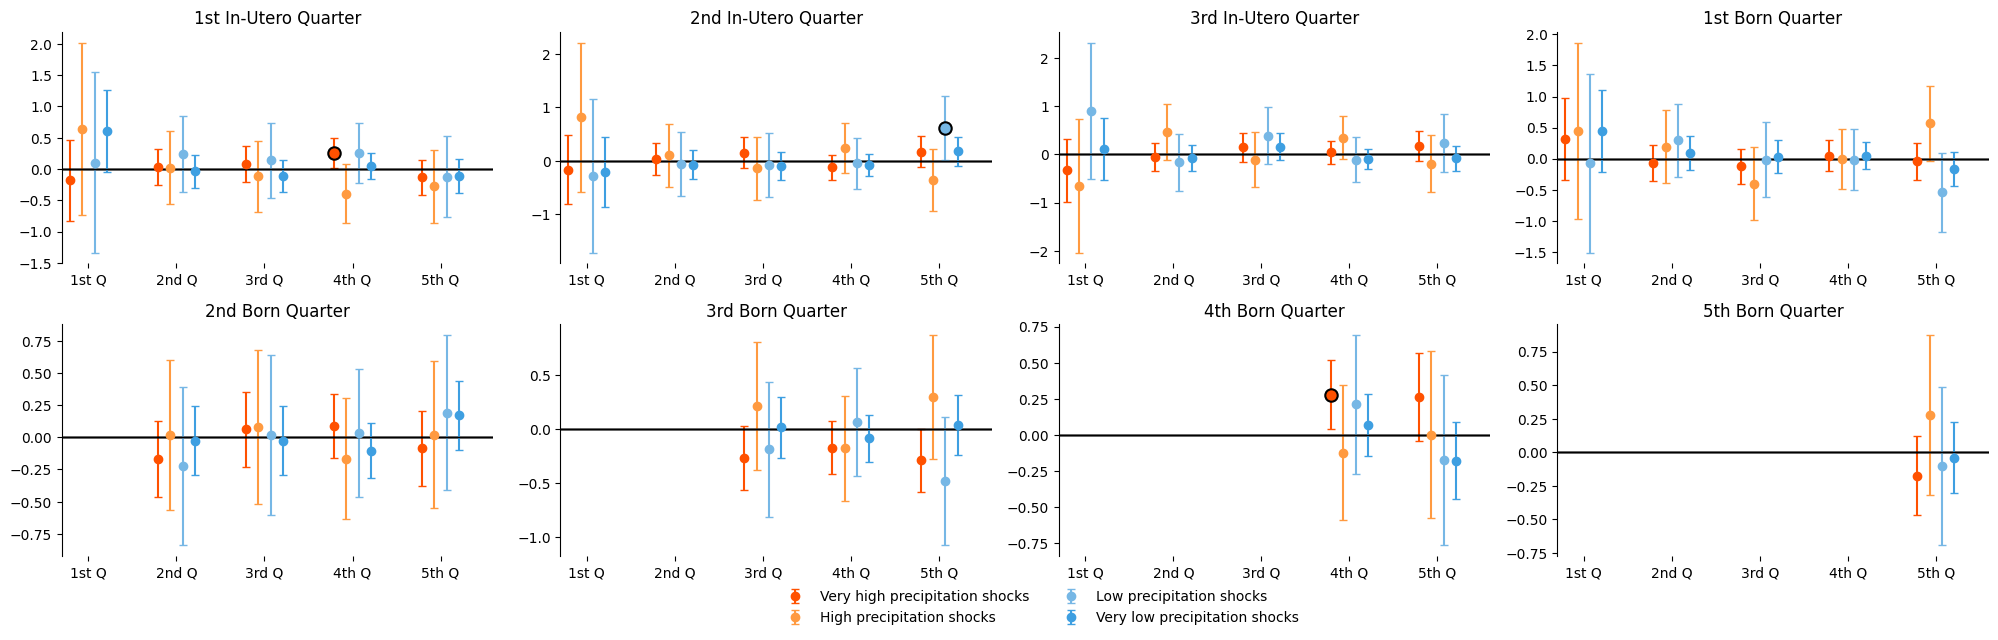

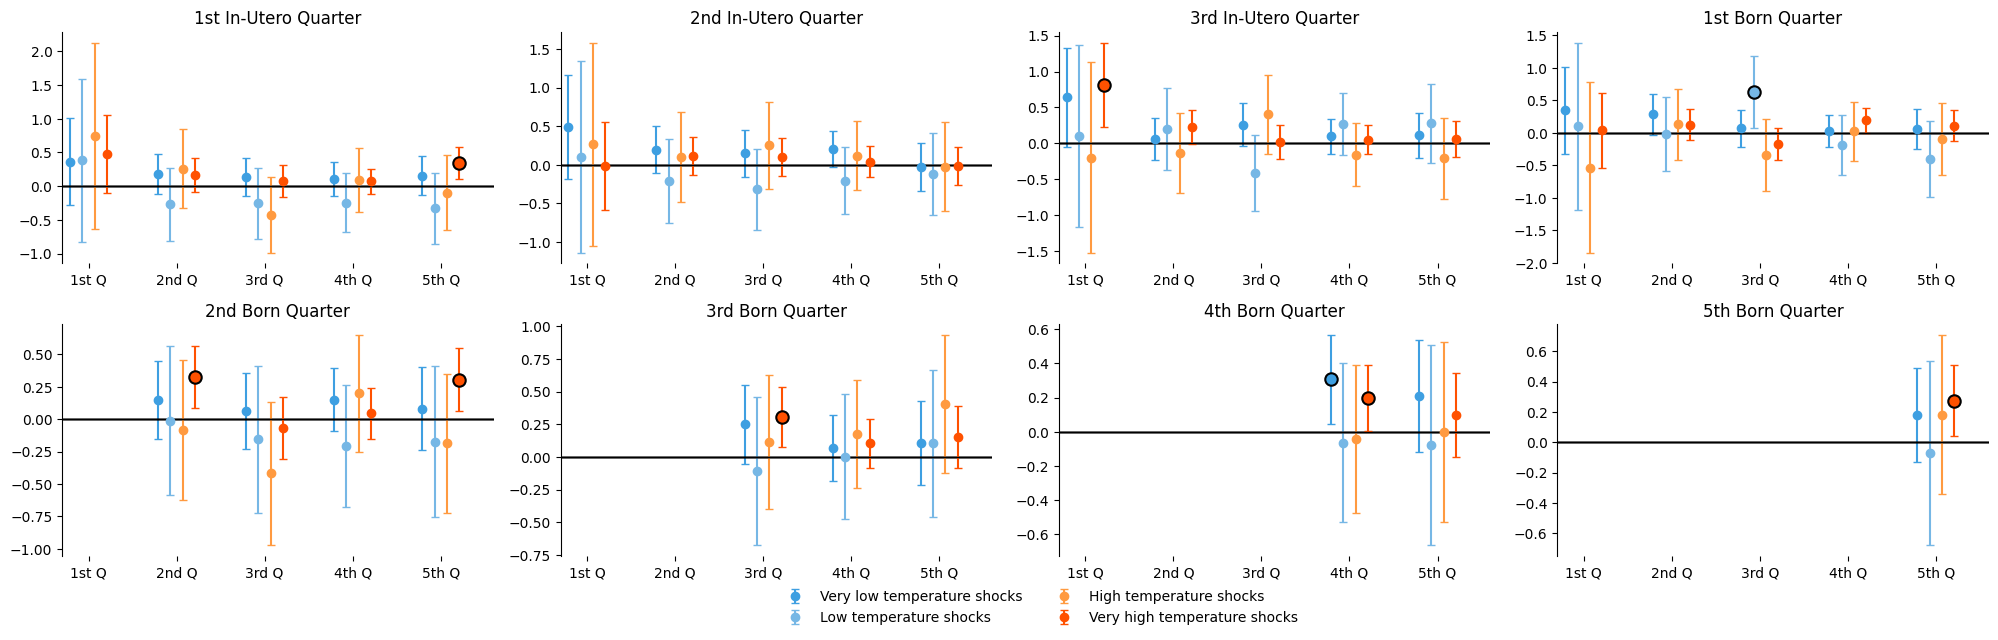

In [58]:
import os
import argparse
import plot_tools
import numpy as np
import pandas as pd
import geopandas as gpd

# Assign variables from command-line arguments
spi  = "spi1"
temp = "stdm_t"
stat = "avg"

DATA_OUT = r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out"
OUTPUTS = r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs"
OUT_FIGS = rf"{OUTPUTS}\Figures\{spi} {temp} {stat}"
os.makedirs(rf"{OUT_FIGS}", exist_ok=True)


file_path = rf"{OUTPUTS}\spline_dummies_false_{spi}_{stat}_{temp}  - spthreshold1 standard_fe.tex"  # Replace with the actual path to your LaTeX file.
outdata = plot_tools.extract_coefficients_and_CI_latex(file_path)

plot_spline_coefficients(
    data=outdata, 
    shock="spi",
    spi=spi,
    temp=temp,
    stat=stat,
    margin=0.15,
    colors = [
        "#ff5100",  # Very high temperature
        "#ff9a40",  # High temperature
        "#76b7e5",  # Low temperature
        "#3e9fe1",   # Very low temperature
    ],
    labels=[
        "Very high precipitation shocks", 
        "High precipitation shocks",
        "Low precipitation shocks", 
        "Very low precipitation shocks",
    ],
    outpath=rf"{OUT_FIGS}"
)

plot_spline_coefficients(
    data=outdata, 
    shock="temp",
    spi=spi,
    temp=temp,
    stat=stat,
    margin=0.15,
    colors = [
        "#3e9fe1",   # Very low temperature
        "#76b7e5",  # Low temperature
        "#ff9a40",  # High temperature
        "#ff5100",  # Very high temperature
    ],
    labels=[
        "Very low temperature shocks",
        "Low temperature shocks", 
        "High temperature shocks",
        "Very high temperature shocks", 
    ],
    outpath=rf"{OUT_FIGS}"
)


In [1]:
import xarray as xr
import numpy as np
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

ds = xr.open_dataset(
    r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\Climate_shocks_v9.nc",
    chunks={"time": -1, "lat": 100, "lon": 100},
)

c:\Users\Nico\miniconda3\envs\climate_indices\Lib\site-packages\xarray\backends\api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)
c:\Users\Nico\miniconda3\envs\climate_indices\Lib\site-packages\xarray\backends\api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


In [40]:

for var in ["spi1", "stdm_t"]:
    da = ds[var]

    # 1) 3‑month running mean (you can choose center=True if you want the mean centered on the window)
    rolling = da.rolling(time=3, center=False).mean()

    # 2) for each lead, shift the rolling mean forward by lead*3 months, then compute corr
    corrs = []
    for q in [1,2,3,4]:
        shifted = rolling.shift(time=-q*3)  # negative shift = future
        # compute correlation along the time axis, dropping NaNs automatically
        r = xr.corr(rolling, shifted, dim='time')
        corrs += [r]

    # 4) combine into a single DataArray with a new 'lead_quarter' coordinate
    corr_da = xr.concat(corrs, dim='lead_quarter')
    corr_da = corr_da.assign_coords(lead_quarter=('lead_quarter', [1,2,3,4]))


    with ProgressBar():
        # corr_da now has dims (lead_quarter: 4, lat: 721, lon: 1440)
        # and corr_da.sel(lead_quarter=1) is the 1‑quarter‑ahead autocorrelation, etc.
        corr_da = corr_da.compute()

    OUT_FIGS = r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\spi1 stdm_t avg"

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))

    corr_da.sel(lead_quarter=1).plot(ax=axs[0][0], vmin=0, vmax=1, cmap="Spectral_r")
    axs[0][0].set_title("1st Quarter Ahead")
    corr_da.sel(lead_quarter=2).plot(ax=axs[0][1], vmin=0, vmax=1, cmap="Spectral_r")
    axs[0][1].set_title("2nd Quarter Ahead")
    corr_da.sel(lead_quarter=3).plot(ax=axs[1][0], vmin=0, vmax=1, cmap="Spectral_r")
    axs[1][0].set_title("3rd Quarter Ahead")
    corr_da.sel(lead_quarter=4).plot(ax=axs[1][1], vmin=0, vmax=1, cmap="Spectral_r")
    axs[1][1].set_title("4th Quarter Ahead")
    plt.tight_layout()

    plt.savefig(rf"{OUT_FIGS}\{var}_autocorr.png", dpi=300, bbox_inches='tight')

1
2
3
4
[########################################] | 100% Completed | 155.36 s


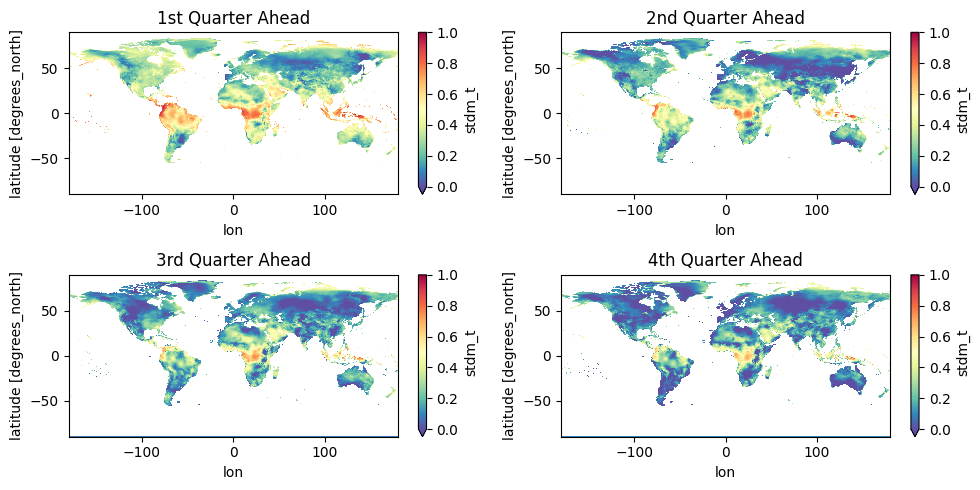

In [50]:
import matplotlib.pyplot as plt
OUT_FIGS = r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\spi1 stdm_t avg"

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

corr_da.sel(lead_quarter=1).plot(ax=axs[0][0], vmin=0, vmax=1, cmap="Spectral_r")
axs[0][0].set_title("1st Quarter Ahead")
corr_da.sel(lead_quarter=2).plot(ax=axs[0][1], vmin=0, vmax=1, cmap="Spectral_r")
axs[0][1].set_title("2nd Quarter Ahead")
corr_da.sel(lead_quarter=3).plot(ax=axs[1][0], vmin=0, vmax=1, cmap="Spectral_r")
axs[1][0].set_title("3rd Quarter Ahead")
corr_da.sel(lead_quarter=4).plot(ax=axs[1][1], vmin=0, vmax=1, cmap="Spectral_r")
axs[1][1].set_title("4th Quarter Ahead")
plt.tight_layout()

plt.savefig(rf"{OUT_FIGS}\stdm_t_autocorr.png", dpi=300, bbox_inches='tight')

In [34]:
with ProgressBar():

    r = r()

[########################################] | 100% Completed | 99.49 s


In [ ]:

# # 4) combine into a single DataArray with a new 'lead_quarter' coordinate
# corr_da = xr.concat(corrs, dim='lead_quarter')
# corr_da = corr_da.assign_coords(lead_quarter=('lead_quarter', leads))

# # corr_da now has dims (lead_quarter: 4, lat: 721, lon: 1440)
# # and corr_da.sel(lead_quarter=1) is the 1‑quarter‑ahead autocorrelation, etc.


inutero_1m3m_avg_ltm1 0
inutero_1m3m_avg_bt0m1 1
inutero_1m3m_avg_bt01 2
inutero_1m3m_avg_gt1 3
inutero_4m6m_avg_ltm1 0
inutero_4m6m_avg_bt0m1 1
inutero_4m6m_avg_bt01 2
inutero_4m6m_avg_gt1 3
inutero_6m9m_avg_ltm1 0
inutero_6m9m_avg_bt0m1 1
inutero_6m9m_avg_bt01 2
inutero_6m9m_avg_gt1 3
born_1m3m_avg_ltm1 0
born_1m3m_avg_bt0m1 1
born_1m3m_avg_bt01 2
born_1m3m_avg_gt1 3
born_3m6m_avg_ltm1 0
born_3m6m_avg_bt0m1 1
born_3m6m_avg_bt01 2
born_3m6m_avg_gt1 3
born_6m9m_avg_ltm1 0
born_6m9m_avg_bt0m1 1
born_6m9m_avg_bt01 2
born_6m9m_avg_gt1 3
born_9m12m_avg_ltm1 0
born_9m12m_avg_bt0m1 1
born_9m12m_avg_bt01 2
born_9m12m_avg_gt1 3
born_12m15m_avg_ltm1 0
born_12m15m_avg_bt0m1 1
born_12m15m_avg_bt01 2
born_12m15m_avg_gt1 3


NameError: name 'outpath' is not defined

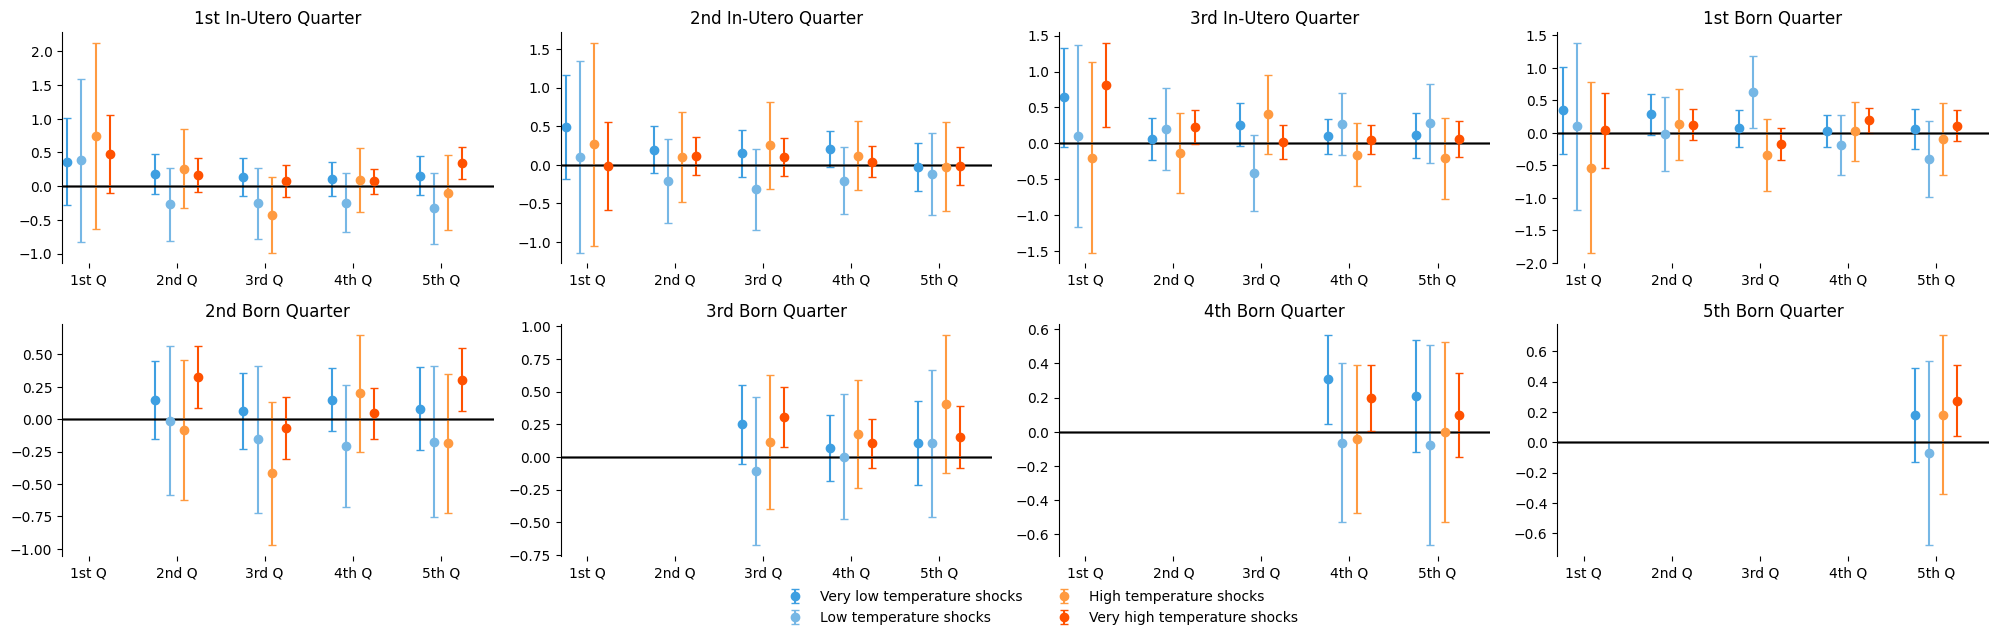

In [45]:
data = outdata
shock = "temp"
margin=0.1
colors = [
    "#3e9fe1",   # Very low temperature
    "#76b7e5",  # Low temperature
    "#ff9a40",  # High temperature
    "#ff5100",  # Very high temperature
]
labels=[
    "Very low temperature shocks",
    "Low temperature shocks", 
    "High temperature shocks",
    "Very high temperature shocks", 
]

import matplotlib.pyplot as plt
import plot_tools

title_labels = {
    "inutero_1m3m": "1st In-Utero Quarter",
    "inutero_4m6m": "2nd In-Utero Quarter",
    "inutero_6m9m": "3rd In-Utero Quarter",
    "born_1m3m": "1st Born Quarter",
    "born_3m6m": "2nd Born Quarter",
    "born_6m9m": "3rd Born Quarter",
    "born_9m12m": "4th Born Quarter",
    "born_12m15m": "5th Born Quarter",
    "born_15m18m": "6th Born Quarter",
}

data = data[shock]["cell1"]

fig, axs = plt.subplots(2, 4, figsize=(20, 6))

xvalues_clean = [0,1,2,3,4]
line_values = []
for i, key in enumerate(data.keys()):
    if i/4==len(axs.flatten()):
        break
    i_round = i // 4
    pos = int((i/4 - i_round )*4)
    
    plotdata = data[key]

    coefs = np.array(plotdata["coef"][:5])
    lower = np.array(plotdata["lower"][:5])
    upper = np.array(plotdata["upper"][:5])
       
    is_neg = ("ltm1" or "bt0m1") in key
    if is_neg:
        coefs = coefs*-1
        old_upper = upper
        upper = lower*-1
        lower = old_upper*-1
    yerr = [
        list(np.subtract(coefs, lower)), # 'down' error
        list(np.subtract(upper, coefs))
    ]  # 'up' error
    
    # Get the color from the cycle
    color = colors[pos]
    label = labels[pos]
    
    ax = axs.flatten()[i_round]

    xvalues = plot_tools.distribute_x_values(xvalues_clean, 4, margin=margin)[pos]
    if pos == 3:
        ax.set_title(title_labels[key.split(f"_{stat}")[0]])
    
    ax.errorbar(xvalues, coefs, yerr=yerr, capsize=3, fmt="o", label=label, color=color)

    # Now call our helper function to highlight points with a lower CI bound > 0.
    # highlight_significant_points(ax, xvalues, coefs, lower, color=color)

    ax.axhline(y=0, color="black", linewidth=1)
    # sns.lineplot(data["inutero_1m3m_avg_pos"]["coef"], ax=ax)
    # sns.despine()
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xvalues_clean, labels=["1st Q", "2nd Q", "3rd Q", "4th Q", "5th Q"])#, "6th Q"])
    ax.set_xlim(-0.3, 4.6)
    line_values += [coefs] 
           
fig.tight_layout()
plt.legend(loc='lower center', bbox_to_anchor=(-1.2, -0.35), ncol=2, frameon=False)

os.makedirs(outpath, exist_ok=True)
filename = fr"{outpath}\{shock}_coefficients_{spi}_{stat}_{temp}.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print("Se creó la figura ", filename)


In [44]:
("ltm1" or "bt0m1") in key


True

In [41]:
key

'born_15m18m_avg_ltm1'

In [40]:
"m1" in key


True

['born_15m18m', '_ltm1']

In [31]:
coefs

array([  nan,   nan,   nan,   nan, -0.04])

In [30]:
xvalues

[0.24, 1.24, 2.24, 3.24, 4.24]

In [12]:
colors

(['#3e9fe1', '#ff5100'],)

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from IPython.display import display

client = Client()
display(client)

df = pd.read_csv(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out\DHSBirthsGlobal&ClimateShocks_v9c.csv", nrows=100_000)
df.dtypes.to_dict()

dtypes = df.dtypes.to_dict()

for key, value in dtypes.items():
    if key == "ID":
        dtypes[key] = str
    
    elif value == "float64":
        dtypes[key] = np.float32
    
    elif value == "int64":
        dtypes[key] = np.int32
        
ddf = dd.read_csv(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out\DHSBirthsGlobal&ClimateShocks_v9c.csv", dtype=dtypes, blocksize="250MB")

with ProgressBar():
    ddf.to_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out\DHSBirthsGlobal&ClimateShocks_v9c.parquet", single_file=True)

<Client: 'tcp://127.0.0.1:59449' processes=4 threads=4, memory=31.88 GiB>

TypeError: __cinit__() got an unexpected keyword argument 'single_file'

In [2]:
pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_out\DHSBirthsGlobal&ClimateShocks_v9c.parquet")

NameError: name 'ddf' is not defined

In [25]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from geocube.vector import vectorize
import matplotlib.pyplot as plt

In [26]:
da = xr.open_dataset(r"D:\Datasets\Köppen-Geiger Climate Classification\KG_1986-2010.grd", engine="rasterio").band_data.sel(band=1)

# To geopandas
gdf = vectorize(da)

## Set legends
# Legends can be found in the R file provided by the official distro: https://koeppen-geiger.vu-wien.ac.at/present.htm
# They are in alphabetical order, so for example Af is band 1 and As band 3. Band 32 is the ocean
# Drop ocean
gdf = gdf[gdf.band_data != 32]

# Assign categories
categories_3 = [
    'Af', 'Am', 'As', 'Aw', 
    'BSh', 'BSk', 'BWh', 'BWk', 
    'Cfa', 'Cfb','Cfc', 'Csa', 'Csb', 'Csc', 'Cwa','Cwb', 'Cwc', 
    'Dfa', 'Dfb', 'Dfc','Dfd', 'Dsa', 'Dsb', 'Dsc', 'Dsd','Dwa', 'Dwb', 'Dwc', 'Dwd', 
    'EF','ET', 
]
labels_3 = dict(zip(range(1, 32), categories_3))
labels_2 = {
    "Af":"Tropical (Rainforest)", 
    "Am":"Tropical (Monsoon)", 
    "As":"Tropical (Savanna, dry winter)", 
    "Aw":"Tropical (Savanna, dry summer)", 
    "BS":"Arid desert", 
    "BW":"Semi-Arid steppe", 
    "Cf":"Temperate (No dry season)", 
    "Cs":"Temperate (Dry summer)", 
    "Cw":"Temperate (Dry winter)", 
    "Df":"Continental (No dry season)", 
    "Ds":"Continental (Dry summer)", 
    "Dw":"Continental (Dry winter)", 
    "EF":"Polar (Tundra)",
    "ET":"Polar (Ice cap)",
}
labels_1 = {"A":"Tropical", "B":"Arid", "C":"Temperate", "D":"Continental", "E":"Polar"}


## Replace values with legends
gdf['climate_band_3'] = gdf['band_data'].map(labels_3)
gdf['climate_band_2'] = gdf['climate_band_3'].str[0:2].map(labels_2)
gdf['climate_band_1'] = gdf['climate_band_3'].str[0].map(labels_1)

In [42]:
mycolors=["#89CFF0", "#4682B4", "#ffd220", "#79c78d", "#fe3500"] 


In [44]:
gdf.climate_band_1.drop_duplicates()

0              Polar
258      Continental
781             Arid
915        Temperate
17547       Tropical
Name: climate_band_1, dtype: object

In [9]:
import pandas as pd
country_classification = pd.read_excel(r"D:\World Bank\Data-Portal-Brief-Generator\Data\Data_Raw\Country codes & metadata\country_classification.xlsx")
country_classification

wbcountryname wbcode                    wbregion        wbincomegroup
0           Aruba    ABW   Latin America & Caribbean          High income
1     Afghanistan    AFG                  South Asia           Low income
2          Angola    AGO          Sub-Saharan Africa  Lower middle income
3         Albania    ALB       Europe & Central Asia  Upper middle income
4         Andorra    AND       Europe & Central Asia          High income
..            ...    ...                         ...                  ...
213        Kosovo    XKX       Europe & Central Asia  Upper middle income
214   Yemen, Rep.    YEM  Middle East & North Africa           Low income
215  South Africa    ZAF          Sub-Saharan Africa  Upper middle income
216        Zambia    ZMB          Sub-Saharan Africa  Lower middle income
217      Zimbabwe    ZWE          Sub-Saharan Africa  Lower middle income

[218 rows x 4 columns]

In [12]:
world_bounds

0      MULTIPOLYGON (((117.70361 4.16341, 117.90704 4...
1      MULTIPOLYGON (((117.70361 4.16341, 117.70167 4...
2      MULTIPOLYGON (((-69.51009 -17.50659, -69.30241...
3      POLYGON ((-69.51009 -17.50659, -69.6228 -17.18...
4      MULTIPOLYGON (((-69.51009 -17.50659, -69.84984...
                             ...                        
246    POLYGON ((-75.02432 18.41726, -75.00699 18.415...
247    POLYGON ((-162.06086 5.88719, -162.07307 5.869...
248    POLYGON ((-162.40018 6.44514, -162.38528 6.445...
249    MULTIPOLYGON (((-171.18566 -9.36126, -171.1883...
250    MULTIPOLYGON (((169.21276 -52.47456, 169.1953 ...
Length: 251, dtype: geometry

In [11]:
import pandas as pd
import geopandas as gpd

world_bounds = gpd.read_file(r"D:\Datasets\World Bank Official Boundaries\WB_countries_Admin0_10m\WB_countries_Admin0_10m.shp").simplify(0.1)

# plot world without fill and with black borders and thin lines
ax = world_bounds.plot(edgecolor='black', facecolor='none', linewidth=0.4, figsize=(10, 5))

# Remove axis
ax.axis('off')
ax.set_xlim(-180, 180)
ax.set_ylim(-65, 85)

# Remove
my_colors=["#89CFF0", "#4682B4", "#ffd220", "#79c78d", "#fe3500"] 

gdf.plot(
    "climate_band_1", 
    ax=ax, 
    cmap=colors.ListedColormap(my_colors), 
    categories=["Polar", "Continental", "Arid", "Temperate", "Tropical"], 
    edgecolor="face", 
    legend=True,
    legend_kwds={"loc": "upper center", "bbox_to_anchor": (0.47, 0.02), "frameon": False, "ncols": 6},
)
world_bounds.plot(edgecolor='black', facecolor='none', linewidth=0.4, ax=ax)
plt.savefig(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\KG_1986-2010.png", dpi=300, bbox_inches="tight")

NameError: name 'stop' is not defined

In [95]:
world_bounds = gpd.read_file(r"D:\Datasets\World Bank Official Boundaries\WB_countries_Admin0_10m\WB_countries_Admin0_10m.shp")
world_bounds["geometry"] = world_bounds.simplify(0.1)
world_bounds.INCOME_GRP = world_bounds.INCOME_GRP.str.replace("1.|2.|3.|4.|5.", "", regex=True).str.strip()
world_bounds.INCOME_GRP = world_bounds.INCOME_GRP.str.replace("High income: nonOECD", "High income")
world_bounds.INCOME_GRP = world_bounds.INCOME_GRP.str.replace("High income: OECD", "High income")


my_colors=["#fe3500", "#ffd220", "#79c78d", "#4682B4", "#89CFF0",] 
# plot world without fill and with black borders and thin lines
ax = world_bounds.plot(    
    "INCOME_GRP", 
    cmap=colors.ListedColormap(my_colors), 
    categories=['Low income', 'Lower middle income', 'Upper middle income', 'High income'], 
    edgecolor="black",
    linewidth=0.4, 
    figsize=(10, 5),
    legend=True,
    legend_kwds={"loc": "upper center", "bbox_to_anchor": (0.47, 0.05), "frameon": False, "ncols": 6},
)

# Remove axis
ax.axis('off')
ax.set_xlim(-180, 180)
ax.set_ylim(-65, 85)
plt.savefig(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Outputs\Figures\Income Groups.png", dpi=300, bbox_inches="tight")

<Axes: >

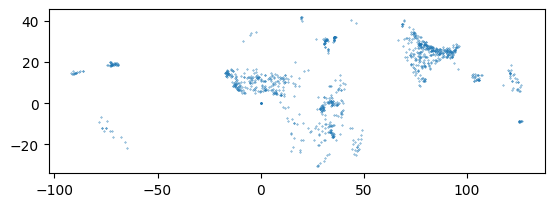

In [13]:
gdf.sample(1000).plot(markersize=.)

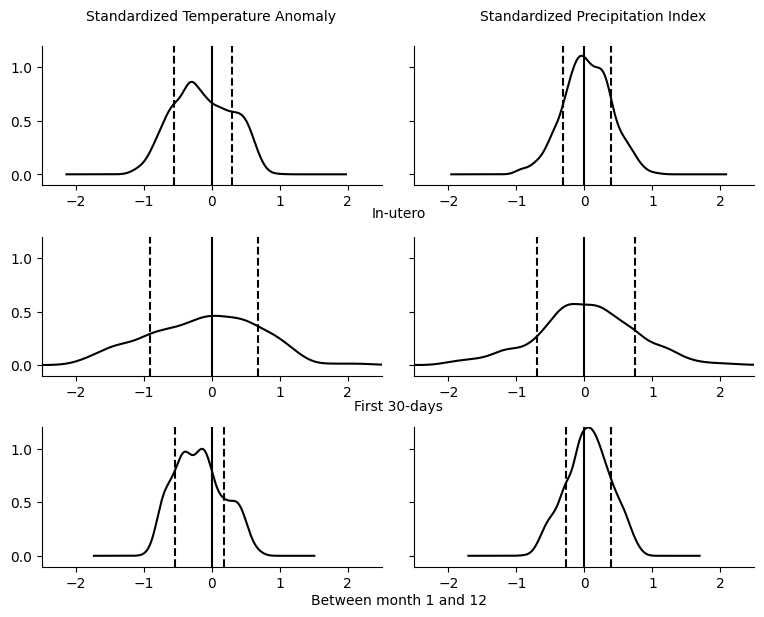

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(8, 6), sharey=True)

for i, ax in enumerate(axs.flatten()):
    col = cols[i]
    # if "spi1" not in col:
    #     continue
    
    s = df[col].head(1_000)
    
    # Compute thresholds
    std = s.std()
    mean = s.mean()
    positive = mean + std
    negative = mean - std
    
    s.plot(kind="kde", color="black", label=col, ax=ax)
    ax.axvline(positive, color="black", linestyle="--")
    ax.axvline(negative, color="black", linestyle="--")
    ax.axvline(0, color="black", linestyle="-")

    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-0.1, 1.2)
    ax.set_ylabel("")
    
    
fig.tight_layout(pad=2)

plt.text(x=-7.33, y=5, s=f"Standardized Temperature Anomaly")
plt.text(x=-1.54, y=5, s=f"Standardized Precipitation Index")

plt.text(x=-2.73, y=3.16, s=f"In-utero", ha="center")
plt.text(x=-2.73, y=1.36, s=f"First 30-days", ha="center")
plt.text(x=-2.73, y=-0.45, s=f"Between month 1 and 12", ha="center")
sns.despine()


In [46]:
6//2 

3

In [39]:
mod(2)

NameError: name 'mod' is not defined

In [1]:
import xarray as xr


stand_temp = xr.open_dataset("d:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021.nc", chunks={})
stand_temp = stand_temp.rename({"t2m": "std_t"})

stand_mtemp = xr.open_dataset("d:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_stdmtemp.nc", chunks={})
stand_mtemp = stand_mtemp.rename({"t2m": "stdm_t"})

temperature = xr.open_dataset("d:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_stdtemp.nc", chunks={})
temperature = temperature.rename({"t2m": "t"})

temps = [temperature["t"], stand_temp["std_t"], stand_mtemp["stdm_t"]]


<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:7: SyntaxWarning: invalid escape sequence '\W'
<>:10: SyntaxWarning: invalid escape sequence '\W'
C:\Users\Nico\AppData\Local\Temp\ipykernel_5500\1871357339.py:4: SyntaxWarning: invalid escape sequence '\W'
  stand_temp = xr.open_dataset("d:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021.nc", chunks={})
C:\Users\Nico\AppData\Local\Temp\ipykernel_5500\1871357339.py:7: SyntaxWarning: invalid escape sequence '\W'
  stand_mtemp = xr.open_dataset("d:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_stdmtemp.nc", chunks={})
C:\Users\Nico\AppData\Local\Temp\ipykernel_5500\1871357339.py:10: SyntaxWarning: invalid escape sequence '\W'
  temperature = xr.open_dataset("d:\World Bank\Paper - Child Mor

In [5]:
ds = xr.combine_by_coords(temps)

In [12]:
spis = spis[0]

In [17]:
unique_indices

array([   0,    1,    2, ..., 1800, 1801, 1802])

In [16]:
spis.lat

<xarray.DataArray 'lat' (lat: 1803)> Size: 7kB
array([-90. , -89.9, -89.8, ...,  89.8,  89.9,  90. ], dtype=float32)
Coordinates:
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0

In [37]:
temps[0]

<xarray.DataArray 't' (time: 1224, lat: 1801, lon: 3600)> Size: 32GB
dask.array<open_dataset-t2m, shape=(1224, 1801, 3600), dtype=float32, chunksize=(95, 139, 277), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * time     (time) datetime64[ns] 10kB 1970-01-01 1970-01-02 ... 2020-12-02

In [38]:
import numpy as np

def drop_duplicate_dims(ds):
    dims = list(ds.dims)
    for dim in dims:
        _, unique_indices = np.unique(ds[dim], return_index=True)

        # Select only the unique values along the x dimension
        ds = ds.isel({dim:unique_indices})
    return ds


drop_duplicate_dims(spis).isel(time=20).spi1.plot()

In [8]:
spis[0]

<xarray.Dataset> Size: 318GB
Dimensions:  (time: 1224, lat: 1803, lon: 3603)
Coordinates:
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 10kB 1970-01-01 1970-01-02 ... 2020-12-02
Data variables:
    spi1     (time, lat, lon) float64 64GB ...
    spi3     (time, lat, lon) float64 64GB ...
    spi6     (time, lat, lon) float64 64GB ...
    spi9     (time, lat, lon) float64 64GB ...
    spi12    (time, lat, lon) float64 64GB ...

In [2]:
spis = [xr.open_dataset("D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_spi.nc")]


<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\Nico\AppData\Local\Temp\ipykernel_5500\2278750713.py:1: SyntaxWarning: invalid escape sequence '\W'
  spis = [xr.open_dataset("D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_spi.nc")]


In [31]:
val_links

0        65680208
42       64275511
96       64341101
126      64275401
157      20142603
           ...   
11483    20070908
11499    67601106
11539    20090901
11556    20061206
11559    20080408
Name: link, Length: 480, dtype: int64

In [38]:
gdf = gpd.read_parquet("G:\Maestría\Tesis\Repo\data\data_in\ICPAG\icpag.parquet")

In [1]:
from dask.distributed import Client

client = Client()

2024-09-18 13:06:22,280 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='D:\\World Bank\\Paper - Child Mortality and Climate Shocks\\Data\\Data_proc\\Climate_shocks_v6_comp.nc', lease_id='6f3a3dd8789a4c03ba8d9725b4ba616c'. This can happen if the Lock or Semaphore timed out before.
2024-09-18 13:10:55,068 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='D:\\World Bank\\Paper - Child Mortality and Climate Shocks\\Data\\Data_proc\\Climate_shocks_v6_comp.nc', lease_id='f6508c4060934b7c8fbb943f9a960f49'. This can happen if the Lock or Semaphore timed out before.
2024-09-18 14:40:11,319 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='D:\\World Bank\\Paper - Child Mortality and Climate Shocks\\Data\\Data_proc\\Climate_shocks_v6_comp.nc', lease_id='9dd972e7b9d44595b96ea7b717951add'. This can happen if the Lock or Semaphore t

In [2]:
client

<Client: 'tcp://127.0.0.1:52519' processes=4 threads=4, memory=31.88 GiB>

In [7]:
import xarray as xr
import numpy as np

ds = xr.open_dataset(r"D:/World Bank/Paper - Child Mortality and Climate Shocks/Data/Data_proc/Climate_shocks_v6.nc", chunks={"lat":300, "lon":300, "time":-1})
ds.isel(lat=slice(0, -1)) # Remove last lat so its multiple of 600
ds = ds.drop("month")

ds = ds.sel(time=ds.time.dt.day == 1)
for coord in ["lat", "lon"]:
    ds[coord] = ds[coord].astype(np.float32)
    round_coords = ds[coord].pipe(lambda x: np.round(x, decimals=1))
    _, counts = np.unique(round_coords, return_counts=True)
    assert len(counts[counts > 1])==0
    ds[coord] = round_coords


# Reduce size
for var in ds.data_vars:
    ds[var] = ds[var].astype(np.float32)

encoding = {
    var: {"zlib": True, "complevel": 9} for var in ds.data_vars
}

# ds = ds.chunk({"lat":100, "lon":100, "time":12})
ds.to_netcdf(r"D:/World Bank/Paper - Child Mortality and Climate Shocks/Data/Data_proc/Climate_shocks_v6_comp.nc", encoding=encoding, engine="h5netcdf", mode='w')

C:\Users\Nico\AppData\Roaming\Python\Python312\site-packages\xarray\core\dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
C:\Users\Nico\AppData\Roaming\Python\Python312\site-packages\xarray\core\dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 300. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
C:\Users\Nico\AppData\Local\Temp\ipykernel_13004\1285520959.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds = ds.drop("month")


In [3]:
pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\DHS_Climate\births_climate_101.parquet")

absdif_t_inutero_avg  absdif_t_30d_avg  absdif_t_2m12m_avg  \
0                 1.295640         -4.606457            0.320420   
1                -0.220062          2.030302           -0.079748   
2                -0.503571         -0.342536           -0.064333   
3                 1.628097         -5.419923            0.305239   
4                 1.043541         -3.566459            0.472498   
...                    ...               ...                 ...   
5785             -1.196031          4.525675           -1.128814   
5786             -2.886621          6.781320           -0.893852   
5787             -2.272510          5.310106           -0.365699   
5788              0.185665          1.851080           -0.093119   
5789             -1.822931          4.976937            0.796606   

      absdif_t_inutero_min  absdif_t_30d_min  absdif_t_2m12m_min  \
0                -3.724906         -4.800589           -4.966808   
1                -3.912759          0.092010           -4.883078   
2                -4.883078         -1.249304           -4.491055   
3                -4.564628         -5.912414           -5.942290   
4                -6.022627         -5.022267           -5.200694   
...                    ...               ...                 ...   
5785             -8.572423          3.774730           -9.819055   
5786             -9.819055          5.598693           -8.594950   
5787             -8.594950          4.911862           -7.930000   
5788             -8.594950         -1.355752           -7.930000   
5789             -8.499937          2.646087           -7.625059   

      absdif_t_inutero_max  absdif_t_30d_max  absdif_t_2m12m_max  \
0                 5.209942         -4.412324            4.270632   
1                 4.626691          3.968593            5.536572   
2                 4.626691          0.564233            5.536572   
3                 6.096722         -4.927433            4.528142   
4                 5.449462         -2.110652            5.633238   
...                    ...               ...                 ...   
5785              6.220551          5.276621            7.963946   
5786              3.207349          7.963946            5.708349   
5787              4.930268          5.708349            7.708373   
5788              7.708373          5.057911            7.621573   
5789              5.827326          7.307788            7.889867   

      spi1_inutero_avg  ...  t_2m12m_avg  t_inutero_min  t_30d_min  \
0             0.098652  ...    16.130076      12.084749  11.009067   
1             0.063391  ...    15.729908      11.896897  15.901666   
2            -0.395526  ...    15.745322      10.926578  14.560351   
3            -0.323478  ...    16.725478      11.855610  10.507824   
4             0.284362  ...    16.892736      10.397611  11.397972   
...                ...  ...          ...            ...        ...   
5785         -0.124242  ...    16.898258       9.454648  21.801802   
5786          0.050384  ...    17.133219       8.208017  23.625765   
5787          0.133922  ...    17.661372       9.432122  22.938934   
5788         -0.112849  ...    17.933953       9.432122  16.671320   
5789         -0.170782  ...    18.823678       9.527135  20.673158   

      t_2m12m_min  t_inutero_max  t_30d_max  t_2m12m_max    lat    lon  \
0       10.842847      21.019597  11.397331    20.080287 -34.25  19.25   
1       10.926578      20.436347  19.778249    21.346228 -34.25  19.25   
2       11.318601      20.436347  16.373889    21.346228 -34.25  19.25   
3       10.477948      22.516960  11.492806    20.948380 -34.25  19.75   
4       11.219544      21.869700  14.309587    22.053476 -34.25  19.75   
...           ...            ...        ...          ...    ...    ...   
5785     8.208017      24.247622  23.303693    25.991018 -28.75  23.25   
5786     9.432122      21.234420  25.991018    23.735421 -28.75  23.25   
5787    10.097072      22.957340  23.735421    2

In [9]:
import pandas as pd

df = pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\DHS_Climate_not_assigned.parquet")
df.iloc[150:200]

absdif_t_inutero_avg  absdif_t_30d_avg  absdif_t_2m12m_avg  \
150             -0.352214          2.019515           -0.169454   
151             -0.352214          2.019515           -0.169454   
152              0.314046         -0.451937           -0.031245   
153              0.314046         -0.451937           -0.031245   
154              0.314046         -0.451937           -0.031245   
155              0.314046         -0.451937           -0.031245   
156              0.903695         -2.989484            0.219114   
157             -0.291301         -0.423491           -0.019861   
158             -1.253444          3.520528           -0.284670   
159             -0.958090          3.379408           -0.151156   
160             -0.958090          3.379408           -0.151156   
161             -0.370674          1.496185            0.019682   
162              0.251219         -0.370817            0.224538   
163              0.626141         -1.612512            0.377758   
164              0.626141         -1.612512            0.377758   
165              1.016463         -2.672534            0.397834   
166              1.016463         -2.672534            0.397834   
167              1.042015         -3.157533            0.430905   
168              0.881825         -3.314874            0.516611   
169              0.881825         -3.314874            0.516611   
170              0.881825         -3.314874            0.516611   
171              0.434450         -2.064258            0.432760   
172             -0.294670          0.041188            0.350512   
173             -0.294670          0.041188            0.350512   
174             -1.101560          4.125660           -0.005743   
175             -0.680416          3.170120            0.104305   
176             -0.102342          1.695500            0.228548   
177             -0.102342          1.695500            0.228548   
178             -0.102342          1.695500            0.228548   
179             -0.102342          1.695500            0.228548   
180              0.382391          0.356909            0.358111   
181              0.985386         -2.054057            0.361592   
182              0.985386         -2.054057            0.361592   
183              0.108311          0.528823            0.093556   
184              0.108311          0.528823            0.093556   
185             -0.291523          1.636248           -0.064549   
186             -0.632383          3.419405            0.092515   
187             -0.383797          2.984101            0.187386   
188              0.661428          0.057753            0.450670   
189              0.661428          0.057753            0.450670   
190              1.074407         -1.641524            0.640995   
191              1.265728         -3.260284            0.776561   
192              1.265728         -3.260284            0.776561   
193              1.265728         -3.260284            0.776561   
194              1.265728         -3.260284            0.776561   
195              1.166081         -3.258606            0.765875   
0               -0.546916          2.182464           -0.768723   
1               -1.217363          1.250157           -0.561904   
2               -1.227736          2.984394           -0.496841   
3               -0.573706          2.231464           -0.331971   

     absdif_t_inutero_min  absdif_t_30d_min  absdif_t_2m12m_min  \
150             -3.290592          0.647416           -4.223537   
151             -3.290592          0.647416           -4.223537   
152             -3.290592         -1.551290           -4.223537   
153             -3.290592         -1.551290           -4.223537   
154             -3.290592         -1.551290           -4.223537   
155             -3.290592         -1.551290           -4.223537   
156             -2.537977         -3.405297           -4.223537   
157             -4.223537         -1.388981        

In [76]:
import os
import logging
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # for notebooks

tqdm.pandas()

pd.options.mode.chained_assignment = None  # default='warn'
logging.getLogger("distributed").setLevel(logging.WARNING)

# Set global variables
PROJECT = r"D:\World Bank\Paper - Child Mortality and Climate Shocks"
OUTPUTS = rf"{PROJECT}\Outputs"
DATA = rf"{PROJECT}\Data"
DATA_IN = rf"{DATA}\Data_in"
DATA_PROC = rf"{DATA}\Data_proc"
DATA_OUT = rf"{DATA}\Data_out"

### Load data #############
print("Loading data...")

### CLIMATE DATA
climate_data_temp = xr.open_dataset(rf"{DATA_PROC}/Climate_shocks_v6.nc", engine="h5netcdf")
climate_data_temp = climate_data_temp[["std_t", "stdm_t", "t"]]

climate_data_spi = xr.open_dataset(rf"{DATA_PROC}/Climate_shocks_v7_spi.nc")

### DHS DATA
full_dhs = pd.read_stata(rf"{DATA_IN}/DHS/DHSBirthsGlobalAnalysis_05142024.dta")
full_dhs["ID"] = full_dhs.index
df = full_dhs.copy()
print("Data loaded! Processing...")

###########################

climate_variables = [
    "spi1",
    "spi3",
    "spi6",
    "spi9",
    "spi12",
    "t",
    "std_t",
    "stdm_t",
]


def round_off(number):
    """Round a number to the closest 0.5.
    >>> round_off(1.3)
    1.5
    >>> round_off(2.6)
    2.5
    """

    return round(number + .4999) - .5

def compute_stats(ds_temp, ds_spi):

    vars = [v for v in ds_temp.data_vars] + [v for v in ds_spi.data_vars]
    arr_temp = ds_temp.to_array().values
    arr_spi = ds_spi.to_array().values
    arr = np.concatenate([arr_temp, arr_spi])

    inutero = arr[:, :9]
    born_1m = arr[:, 9:11]
    born_2to12m = arr[:, 11:22]

    assert inutero.shape[1] == 9  # 9 months in utero
    assert born_1m.shape[1] == 2
    # 1 month after birth (a little bit more because we dont have climate data for the exact day of birth. On average is one month)
    assert born_2to12m.shape[1] == 11  # next 11 months after birth

    # Compute stats using numpy for efficiency
    inutero = {
        f"{var}_inutero_avg": value
        for var, value in zip(vars, np.nanmean(inutero, axis=1))
    }
    born_1m = {
        f"{var}_30d_avg": value
        for var, value in zip(vars, np.nanmean(born_1m, axis=1))
    }
    born_2to12m = {
        f"{var}_2m12m_avg": value
        for var, value in zip(vars, np.nanmean(born_2to12m, axis=1))
    }

    results = {**inutero, **born_1m, **born_2to12m}
    results = pd.Series(results)
    return results

def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point and time
    point_data_temp = climate_data_temp.sel(
        time=slice(from_date, to_date), lat=lat, lon=lon
    )

    point_data_spi = climate_data_spi.sel(
        time=slice(from_date, to_date), lat=round_off(lat), lon=round_off(lon)
    )

    out = compute_stats(point_data_temp, point_data_spi)

    return out

### Process dataframe ####
# Create datetime object from year and month
df["day"] = 1
df["month"] = df["chb_month"].astype(float)
df["year"] = df["chb_year"].astype(float)
df["birthdate"] = pd.to_datetime(df[["year", "month", "day"]]).to_numpy()

# Maximum range of dates
df["from_date"] = df["birthdate"] + pd.DateOffset(
    months=-9
)  # From in utero (9 months before birth)
df["to_date"] = df["birthdate"] + pd.DateOffset(
    months=13
)  # To the first year of life

# Filter children from_date greater than 1990 (we only have climate data from 1990)
df = df[df["from_date"] > "1990-01-01"]

# Filter children to_date smalle than 2021 (we only have climate data to 2020)
df = df[df["to_date"] < "2021-01-01"]

df["lat_round"] = df["LATNUM"].apply(lambda x: np.round(x, decimals=1))
df["lon_round"] = df["LONGNUM"].apply(lambda x: np.round(x, decimals=1))
df = df.reset_index(drop=True)

### Run process ####
coords_cols = ["lat_climate", "lon_climate"]
shock_cols = []

print("Assigning climate shocks to DHS data...")


Loading data...
Data loaded! Processing...
Assigning climate shocks to DHS data...


In [83]:
def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point and time
    point_data_temp = climate_data_temp.sel(
        time=slice(from_date, to_date), lat=lat, lon=lon
    )

    point_data_spi = climate_data_spi.sel(
        time=slice(from_date, to_date), lat=round_off(lat), lon=round_off(lon)
    )

    return point_data_temp, point_data_spi
    out = compute_stats(point_data_temp, point_data_spi)

    return out


In [150]:
climate_data_spi

<xarray.Dataset> Size: 871MB
Dimensions:  (lat: 180, lon: 360, time: 480)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2020-12-01
Data variables:
    spi1     (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi3     (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi6     (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi9     (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi12    (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi24    (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
    spi48    (time, lat, lon) float32 124MB dask.array<chunksize=(480, 100, 100), meta=np.ndarray>
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Standardized Precipitation Index, 01-month ac...
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/0a92348b-20c1-4689-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 1.2.0 covers data fr...

In [152]:
climate_data_temp

<xarray.Dataset> Size: 48GB
Dimensions:  (time: 612, lat: 1801, lon: 3600)
Coordinates:
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float32 14kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
Data variables:
    std_t    (time, lat, lon) float32 16GB ...
    stdm_t   (time, lat, lon) float32 16GB ...
    t        (time, lat, lon) float32 16GB ...

In [142]:
# climate_data_temp = xr.open_dataset(rf"{DATA_PROC}/Climate_shocks_v6.nc", engine="h5netcdf")
# climate_data_temp = climate_data_temp[["std_t", "stdm_t", "t"]]

climate_data_spi = xr.open_dataset(rf"{DATA_PROC}/Climate_shocks_v7_spi.nc", chunks={"lat":100, "lon":100, "time":-1})

C:\Users\Nico\AppData\Roaming\Python\Python312\site-packages\xarray\core\dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
C:\Users\Nico\AppData\Roaming\Python\Python312\site-packages\xarray\core\dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [92]:
ds_spi.to_array()

<xarray.DataArray (variable: 7, time: 23)> Size: 644B
array([[ 0.248,  1.135,  0.084,  2.16 , -0.533,  1.77 , -0.878, -1.537,
        -1.243, -0.103,  1.075, -0.868, -0.269,  0.341,  0.084, -0.842,
        -0.218, -1.754, -0.48 , -1.144, -1.941, -1.197,  1.136],
       [-0.124,  0.335,  0.353,  1.358,  0.519,  1.885,  0.297, -0.777,
        -1.836, -1.366, -0.071,  0.171,  0.158, -0.969, -0.503, -1.111,
        -0.969, -1.744, -1.133, -1.511, -1.895, -2.302, -0.871],
       [ 0.416,  0.763,  0.343,  0.009,  0.366,  1.125,  0.637, -0.748,
        -1.179, -1.145, -0.464, -0.965, -0.817, -0.485, -0.038,  0.01 ,
        -1.094, -1.162, -1.531, -1.702, -2.188, -2.487, -1.489],
       [ 0.429,  0.397,  0.473,  0.49 ,  0.781,  0.653,  0.072, -0.279,
        -0.927, -0.994, -0.438, -0.626, -0.747, -0.744, -1.03 , -0.882,
        -0.551, -0.253, -0.477, -1.761, -2.153, -2.568, -1.542],
       [ 0.38 ,  0.448,  0.441,  0.534,  0.443,  0.734,  0.532,  0.389,
        -0.421, -0.902, -0.273, -0.547, -0.65 , -0.722, -0.723, -0.757,
        -0.749, -1.117, -1.206, -1.046, -1.237, -1.839, -1.773],
       [-0.765, -0.715, -0.711, -0.671, -0.688, -0.433, -0.639, -0.897,
        -1.043, -0.687, -0.125, -0.302, -0.187, -0.188, -0.19 , -0.198,
        -0.263, -0.28 , -0.463, -0.454, -1.166, -1.822, -1.449],
       [ 0.453,  0.492,  0.484,  0.501,  0.497,  0.551,  0.294,  0.194,
         0.114, -0.337,  0.026, -0.266, -0.571, -0.57 , -0.575, -0.606,
        -0.6  , -0.731, -0.804, -0.919, -1.184, -1.411, -1.52 ]],
      dtype=float32)
Coordinates:
    lat       float64 8B 25.5
    lon       float64 8B 90.5
  * time      (time) datetime64[ns] 184B 2007-10-01 2007-11-01 ... 2009-08-01
  * variable  (variable) object 56B 'spi1' 'spi3' 'spi6' ... 'spi24' 'spi48'
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Standardized Precipitation Index, 01-month ac...
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/0a92348b-20c1-4689-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 1.2.0 covers data fr...

In [147]:
def compute_stats(ds_temp, ds_spi):
    # Initialize an empty dictionary to store results
    results = {}
    
    # Define the time slices
    inutero_slice = slice(0, 9)
    born_1m_slice = slice(9, 11)
    born_2to12m_slice = slice(11, 22)
    
    # # Process variables in ds_temp
    for var in ds_temp.data_vars:
        data = ds_temp[var].load()
        results[f"{var}_inutero_avg"] = data.isel(time=inutero_slice).mean().item()
        results[f"{var}_30d_avg"] = data.isel(time=born_1m_slice).mean().item()
        results[f"{var}_2m12m_avg"] = data.isel(time=born_2to12m_slice).mean().item()
    
    # Process variables in ds_spi
    for var in ds_spi.data_vars:
        data = ds_spi[var].load()
        results[f"{var}_inutero_avg"] = data.isel(time=inutero_slice).mean().item()
        results[f"{var}_30d_avg"] = data.isel(time=born_1m_slice).mean().item()
        results[f"{var}_2m12m_avg"] = data.isel(time=born_2to12m_slice).mean().item()
    
    # Convert results to pandas Series
    results_series = pd.Series(results)
    return results_series


In [129]:
ds_spi

<xarray.Dataset> Size: 844B
Dimensions:  (time: 23)
Coordinates:
    lat      float64 8B 23.5
    lon      float64 8B 84.5
  * time     (time) datetime64[ns] 184B 2007-11-01 2007-12-01 ... 2009-09-01
Data variables:
    spi1     (time) float32 92B ...
    spi3     (time) float32 92B ...
    spi6     (time) float32 92B ...
    spi9     (time) float32 92B ...
    spi12    (time) float32 92B ...
    spi24    (time) float32 92B ...
    spi48    (time) float32 92B ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Standardized Precipitation Index, 01-month ac...
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/0a92348b-20c1-4689-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 1.2.0 covers data fr...

In [135]:
df = df.sort_values(["lat_round",	"lon_round"])

In [136]:
i = 0

In [149]:
%%timeit


s = df.sample(1)
ds_temp, ds_spi = get_climate_shock(
    s["from_date"].item(),
    s["to_date"].item(),
    s["lat_round"].item(),
    s["lon_round"].item(),
)

compute_stats(ds_temp, ds_spi)



536 ms ± 185 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
from line_profiler import LineProfiler

s = df.sample(1)
ds_temp, ds_spi = get_climate_shock(
    s["from_date"].item(),
    s["to_date"].item(),
    s["lat_round"].item(),
    s["lon_round"].item(),
)

lp = LineProfiler()
lp_wrapper = lp(compute_stats)
lp_wrapper(
    ds_temp, ds_spi
)
lp.print_stats()


Timer unit: 1e-07 s

Total time: 0.0940129 s
File: C:\Users\Nico\AppData\Local\Temp\ipykernel_14552\1381528832.py
Function: compute_stats at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def compute_stats(ds_temp, ds_spi):
     2                                               # Initialize an empty dictionary to store results
     3         1          5.0      5.0      0.0      results = {}
     4                                               
     5                                               # Define the time slices
     6         1         10.0     10.0      0.0      inutero_slice = slice(0, 9)
     7         1          5.0      5.0      0.0      born_1m_slice = slice(9, 11)
     8         1          4.0      4.0      0.0      born_2to12m_slice = slice(11, 22)
     9                                               
    10                                               # # Process variables in ds_temp
    11      

In [ ]:
climate_results = chunk.progress_apply(
    lambda s: get_climate_shock(
        s["from_date"],
        s["to_date"],
        s["lat_round"],
        s["lon_round"],
    ),
    axis=1,
)


In [ ]:
chunk_size = 100
for n in tqdm(range(0, df.index.max(), chunk_size)):

    file = rf"{DATA_PROC}/births_climate_{n}.parquet"
    if os.path.exists(file):
        print(f"{file} exists, moving to next iteration")
        continue

    chunk = df.loc[
        (df.index >= n) & (df.index < n + chunk_size),
        ["ID", "from_date", "to_date", "lat_round", "lon_round"],
    ].copy()

    climate_results = chunk.progress_apply(
        lambda s: get_climate_shock(
            s["from_date"],
            s["to_date"],
            s["lat_round"],
            s["lon_round"],
        ),
        axis=1,
    )

    # Save results into a df
    climate_results = climate_results.apply(pd.Series)
    climate_results["ID"] = chunk["ID"]
    climate_results["lat"] = chunk["lat_round"]
    climate_results["lon"] = chunk["lon_round"]
    climate_results.to_parquet(file, index=False)

In [1]:
PROJECT = r"D:\World Bank\Paper - Child Mortality and Climate Shocks"
OUTPUTS = rf"{PROJECT}\Outputs"
DATA = rf"{PROJECT}\Data"
DATA_IN = rf"{DATA}\Data_in"
DATA_PROC = rf"{DATA}\Data_proc"
DATA_OUT = rf"{DATA}\Data_out"

import xarray as xr
import pandas as pd
import numpy as np

climate_data = xr.open_dataset(rf"{DATA_PROC}/Climate_shocks_v6.nc", engine="h5netcdf")
print(climate_data)
stop
dates = climate_data.time.values


full_dhs = pd.read_stata(rf"{DATA_IN}/DHS/DHSBirthsGlobalAnalysis_05142024.dta")
full_dhs["ID"] = full_dhs.index
df = full_dhs.copy()
print("Data loaded! Processing...")

###########################

climate_variables = [
    "spi1",
    "spi3",
    "spi6",
    "spi9",
    "spi12",
    "t",
    "std_t",
    "stdm_t",
]

def compute_stats(ds):

    arr = ds.to_array().values
    inutero = arr[:, :9]
    born_1m = arr[:, 9:11]
    born_2to12m = arr[:, 11:22]

    assert inutero.shape[1] == 9  # 9 months in utero
    assert born_1m.shape[1] == 2
    # 1 month after birth (a little bit more because we dont have climate data for the exact day of birth. On average is one month)
    assert born_2to12m.shape[1] == 11  # next 11 months after birth

    # Compute stats using numpy for efficiency
    inutero = {
        f"{var}_inutero_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(inutero, axis=1))
    }
    born_1m = {
        f"{var}_30d_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(born_1m, axis=1))
    }
    born_2to12m = {
        f"{var}_2m12m_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(born_2to12m, axis=1))
    }

    results = {**inutero, **born_1m, **born_2to12m}
    results = pd.Series(results)
    return results

def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point
    # climate_data_vars = climate_data[climate_variables]
    point_data = climate_data.sel(time=slice(from_date, to_date)).sel(
        lat=lat, lon=lon
    )

    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()

    # Filter by time
    inutero_to_1st_year = point_data.isel(time=slice(0, 22))
    out = compute_stats(inutero_to_1st_year)
    # Agregar columnas acá...
    return out

### Process dataframe ####
# Create datetime object from year and month
df["day"] = 1
df["month"] = df["chb_month"].astype(float)
df["year"] = df["chb_year"].astype(float)
df["birthdate"] = pd.to_datetime(df[["year", "month", "day"]]).to_numpy()

# Maximum range of dates
df["from_date"] = df["birthdate"] + pd.DateOffset(
    months=-9
)  # From in utero (9 months before birth)
df["to_date"] = df["birthdate"] + pd.DateOffset(
    months=13
)  # To the first year of life

# Filter children from_date greater than 1990 (we only have climate data from 1990)
df = df[df["from_date"] > "1990-01-01"]

# Filter children to_date smalle than 2021 (we only have climate data to 2020)
df = df[df["to_date"] < "2021-01-01"]

df["lat_round"] = df["LATNUM"].apply(lambda x: np.round(x, decimals=1))
df["lon_round"] = df["LONGNUM"].apply(lambda x: np.round(x, decimals=1))
df = df.reset_index(drop=True)

### Run process ####
coords_cols = ["lat_climate", "lon_climate"]
shock_cols = []


<xarray.Dataset> Size: 127GB
Dimensions:  (time: 612, lat: 1801, lon: 3600)
Coordinates:
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float32 14kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
Data variables:
    spi1     (time, lat, lon) float32 16GB ...
    spi3     (time, lat, lon) float32 16GB ...
    spi6     (time, lat, lon) float32 16GB ...
    spi9     (time, lat, lon) float32 16GB ...
    spi12    (time, lat, lon) float32 16GB ...
    std_t    (time, lat, lon) float32 16GB ...
    stdm_t   (time, lat, lon) float32 16GB ...
    t        (time, lat, lon) float32 16GB ...


NameError: name 'stop' is not defined

In [8]:
climate_data.rio.set_spatial_dims("lon", "lat", inplace=True)
climate_data

<xarray.Dataset> Size: 127GB
Dimensions:  (time: 612, lat: 1801, lon: 3600)
Coordinates:
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * lon      (lon) float32 14kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
Data variables:
    spi1     (time, lat, lon) float32 16GB ...
    spi3     (time, lat, lon) float32 16GB ...
    spi6     (time, lat, lon) float32 16GB ...
    spi9     (time, lat, lon) float32 16GB ...
    spi12    (time, lat, lon) float32 16GB ...
    std_t    (time, lat, lon) float32 16GB ...
    stdm_t   (time, lat, lon) float32 16GB ...
    t        (time, lat, lon) float32 16GB ...

In [13]:
climate_data

<xarray.Dataset> Size: 127GB
Dimensions:  (time: 612, y: 1801, x: 3600)
Coordinates:
  * y        (y) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * x        (x) float32 14kB -179.9 -179.8 -179.7 -179.6 ... 179.8 179.9 180.0
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2020-12-01
Data variables:
    spi1     (time, y, x) float32 16GB ...
    spi3     (time, y, x) float32 16GB ...
    spi6     (time, y, x) float32 16GB ...
    spi9     (time, y, x) float32 16GB ...
    spi12    (time, y, x) float32 16GB ...
    std_t    (time, y, x) float32 16GB ...
    stdm_t   (time, y, x) float32 16GB ...
    t        (time, y, x) float32 16GB ...

In [12]:
climate_data = climate_data.rename({"lat":"y","lon":"x"})
climate_data

ValueError: cannot rename 'lat' because it is not a variable or dimension in this dataset

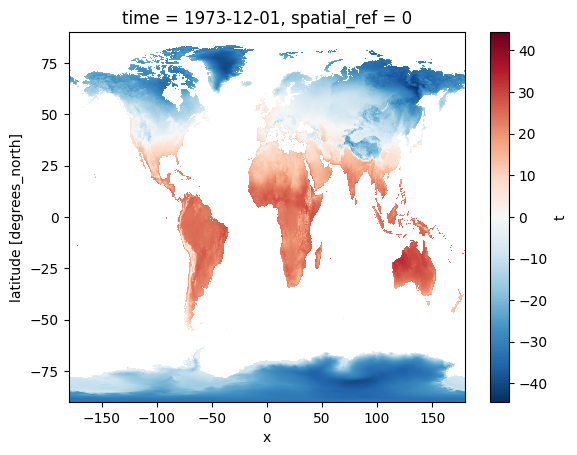

In [51]:
climate_data = climate_data.rio.write_crs("epsg:4326")
climate_data.t.isel(time=47).plot()

In [50]:
ds = xr.open_dataset(r"C:\Users\Nico\Downloads\spg01_m_wld_19810101_19811201_m.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 96B 1981-01-01 1981-02-01 ... 1981-12-01
Data variables:
    spg01    (time, lat, lon) float32 3MB ...
    4326     float32 4B ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Standardized Precipitation Index, 01-month ac...
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/0a92348b-20c1-4689-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 1.2.0 covers data fr...

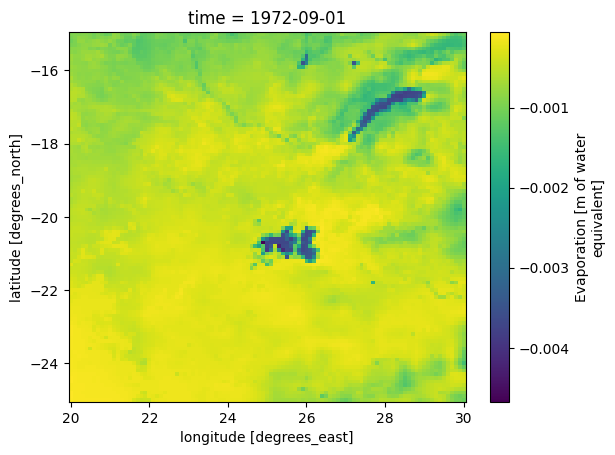

In [30]:
era5data = xr.open_dataset(r"D:\Datasets\ERA5 Reanalysis\monthly-land\data_1972.nc")
era5data.sel(longitude=slice(20, 30), latitude=slice(-15, -25)).isel(time=16).e.plot()

20.4 42.2


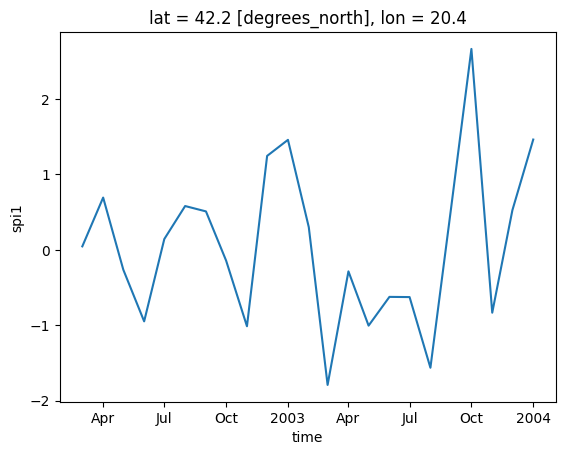

In [66]:
i = 817

lat = df.iloc[i].lat_round
lon = df.iloc[i].lon_round
from_dt = df.iloc[i].from_date
to_dt =   df.iloc[i].to_date
print(lon, lat)

climate_data.sel(lat=lat, lon=lon, time=slice(from_dt, to_dt)).spi1.plot()

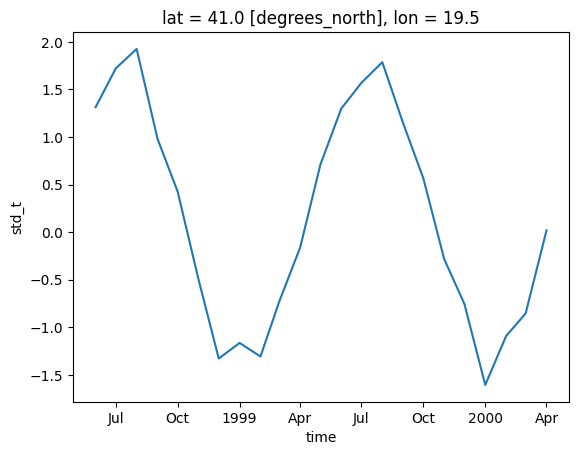

In [7]:
ds.lon

<xarray.DataArray 'lon' (lon: 3600)> Size: 14kB
array([-179.9, -179.8, -179.7, ...,  179.8,  179.9,  180. ], dtype=float32)
Coordinates:
  * lon      (lon) float32 14kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

In [5]:
import pandas as pd

def compute_stats(ds):

    arr = ds.to_array().values
    inutero = arr[:, :9]
    born_1m = arr[:, 9:11]
    born_2to12m = arr[:, 11:22]

    assert inutero.shape[1] == 9  # 9 months in utero
    assert born_1m.shape[1] == 2
    # 1 month after birth (a little bit more because we dont have climate data for the exact day of birth. On average is one month)
    assert born_2to12m.shape[1] == 11  # next 11 months after birth

    # Compute stats using numpy for efficiency
    inutero = {
        f"{var}_inutero_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(inutero, axis=1))
    }
    born_1m = {
        f"{var}_30d_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(born_1m, axis=1))
    }
    born_2to12m = {
        f"{var}_2m12m_avg": value
        for var, value in zip(ds.data_vars, np.nanmean(born_2to12m, axis=1))
    }

    results = {**inutero, **born_1m, **born_2to12m}
    results = pd.Series(results)
    return results

def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point
    # climate_data_vars = climate_data[climate_variables]
    point_data = ds.sel(time=slice(from_date, to_date)).sel(
        lat=lat, lon=lon
    )

    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()

    # Filter by time
    inutero_to_1st_year = point_data.isel(time=slice(0, 22))
    out = compute_stats(inutero_to_1st_year)
    # Agregar columnas acá...
    return out


# full_dhs = pd.read_stata(rf"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_in\DHS/DHSBirthsGlobalAnalysis_05142024.dta")
# full_dhs

In [9]:
import numpy as np

In [234]:
df = full_dhs
### Process dataframe ####
# Create datetime object from year and month
df["day"] = 1
df["month"] = df["chb_month"].astype(float)
df["year"] = df["chb_year"].astype(float)
df["birthdate"] = pd.to_datetime(df[["year", "month", "day"]]).to_numpy()

# Maximum range of dates
df["from_date"] = df["birthdate"] + pd.DateOffset(
    months=-8 #### CAMBIO
)  # From in utero (9 months before birth)
df["to_date"] = df["birthdate"] + pd.DateOffset(
    months=13
)  # To the first year of life

# Filter children from_date greater than 1990 (we only have climate data from 1990)
df = df[df["from_date"] > "1990-01-01"]

# Filter children to_date smalle than 2021 (we only have climate data to 2020)
df = df[df["to_date"] < "2021-01-01"]

In [227]:
df["lat_round"] = df["LATNUM"].apply(lambda x: np.round(x, decimals=1))
df["lon_round"] = df["LONGNUM"].apply(lambda x: np.round(x, decimals=1))
df = df.reset_index(drop=True)


In [250]:
import profile

In [253]:
from line_profiler import LineProfiler

def compute_stats(ds):
    # Define time slices using slice objects for clarity
    inutero_slice = slice(0, 9)
    born_1m_slice = slice(9, 11)
    born_2to12m_slice = slice(11, 22)

    # Compute means directly using xarray's optimized methods
    inutero_mean = ds.isel(time=inutero_slice).mean(dim='time')
    born_1m_mean = ds.isel(time=born_1m_slice).mean(dim='time')
    born_2to12m_mean = ds.isel(time=born_2to12m_slice).mean(dim='time')

    # Build the results dictionary
    results = {}
    for var in ds.data_vars:
        results[f"{var}_inutero_avg"] = inutero_mean[var].item()
        results[f"{var}_30d_avg"] = born_1m_mean[var].item()
        results[f"{var}_2m12m_avg"] = born_2to12m_mean[var].item()

    return pd.Series(results)

def get_climate_shock(ds, from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Select the point data efficiently using xarray's selection methods
    point_data = ds.sel(time=slice(from_date, to_date), lat=lat, lon=lon)

    # Check if there is sufficient data
    if point_data.time.size < 22:
        return np.nan  # or handle this case as appropriate
    return point_data

    out = compute_stats(point_data)
    return out




In [270]:
s = df.sample(1)
point_data = get_climate_shock(ds,
        s["from_date"].item(),
        s["to_date"].item(),
        s["lat_round"].item(),
        s["lon_round"].item(),)


In [271]:

data_vars = list(point_data.data_vars)

# Convert all variables into a single NumPy array: shape (variables, time)
data_array = np.stack([point_data[var].values for var in data_vars])

# Define time indices
inutero_indices = slice(0, 9)

# Compute means over specified time slices
inutero_mean = data_array[:, inutero_indices].mean(axis=1)

# Compute means directly using xarray's optimized methods
# inutero_mean = point_data.isel(time=inutero_slice).mean(dim='time')


In [272]:
inutero_mean

array([ 0.47249513,  0.40726994,  0.06891055, -0.09899405, -0.50027833,
        0.45669516,  0.51021874, 26.26730347])

In [254]:
lp = LineProfiler()
s = df.sample(1)
point_data = get_climate_shock(ds,
        s["from_date"].item(),
        s["to_date"].item(),
        s["lat_round"].item(),
        s["lon_round"].item(),)
lp_wrapper = lp(compute_stats)
lp_wrapper(point_data)
lp.print_stats()


Timer unit: 1e-07 s

Total time: 0.876443 s
File: C:\Users\Nico\AppData\Local\Temp\ipykernel_15432\1544090344.py
Function: compute_stats at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def compute_stats(ds):
     4                                               # Define time slices using slice objects for clarity
     5         1         11.0     11.0      0.0      inutero_slice = slice(0, 9)
     6         1          6.0      6.0      0.0      born_1m_slice = slice(9, 11)
     7         1          4.0      4.0      0.0      born_2to12m_slice = slice(11, 22)
     8                                           
     9                                               # Compute means directly using xarray's optimized methods
    10         1    8379761.0    8e+06     95.6      inutero_mean = ds.isel(time=inutero_slice).mean(dim='time')
    11         1     192020.0 192020.0      2.2      born_1m_mean = ds.isel(time=born_1

In [92]:
era5 = xr.open_dataset(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021.nc")

In [91]:
b.isel(time=1).stdm_t.item()

-1.3032104969024658

In [71]:
b.isel(time=1).spi1.item()

-0.5229370456435194

In [120]:
era5.isel(time=684).e.plot()

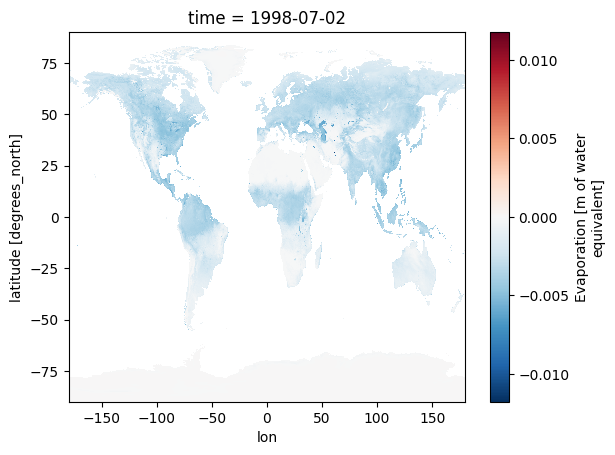

In [119]:
era5.isel(time=685).e.plot()

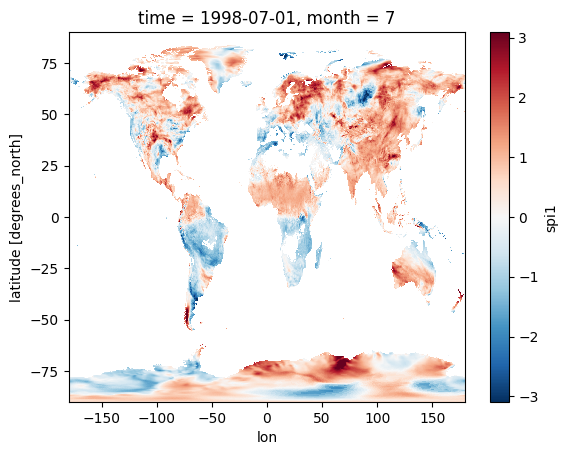

In [106]:
# ds = ds.sel(time=ds.time.dt.day == 1)
ds.isel(time=342).spi1.plot()

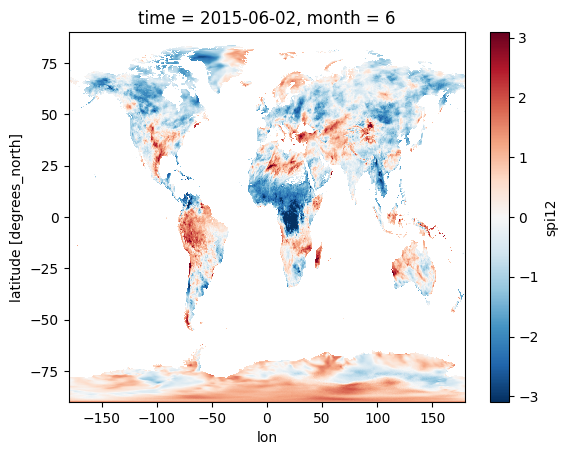

In [127]:
ds.isel(time=1091).spi12.plot()

In [38]:
%%timeit

s = df.sample(1)

get_climate_shock(
        ds,
        s["from_date"].item(),
        s["to_date"].item(),
        s["lat_round"].item(),
        s["lon_round"].item(),
    )


847 ms ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit

s = df.sample(1)

get_climate_shock(
        s["from_date"].item(),
        s["to_date"].item(),
        s["lat_round"].item(),
        s["lon_round"].item(),
    ),


TypeError: get_climate_shock() missing 1 required positional argument: 'lon'

In [63]:

import numpy as np

def round_coord(dataset):
    return dataset.map(lambda a: np.round(a, decimals=2))

round_lons = ds.lon.pipe(lambda x: np.round(x, decimals=2))
_, counts = np.unique(round_lons, return_counts=True)
assert len(counts[counts > 1])==0

In [81]:

import pandas as pd
pd.Series(ds.lat.values).apply(lambda x: np.round(x, decimals=1))

0      -90.0
1      -89.9
2      -89.8
3      -89.7
4      -89.6
        ... 
1796    89.6
1797    89.7
1798    89.8
1799    89.9
1800    90.0
Length: 1801, dtype: float64

In [101]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20,15))

ds = xr.open_dataset(r"D:\Downloads\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2001-geotiff\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2001.tif")#.plot()
ds = ds.sel(band=1)

# Select honduras
ds = ds.sel(x=slice(-90, -82), y=slice(16, 12))
ds.band_data.plot(ax=ax)


gdf.plot(facecolor='none', edgecolor='black', ax=ax)

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

In [114]:
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

def assign_contamination_to_point(point):

    point_data = ds.sel(x=point.x, y=point.y, method="nearest")
    contamination = point_data.band_data.item()

    return contamination

# Honduras municipality shapefile
gdf = gpd.read_file(r"D:\Downloads\municipios\710ebc5a-2d41-4d60-851e-84663c2f72df.zip")
gdf = gdf.to_crs("EPSG:4326")

# Worldwide PM 2.5 data
data_a = r"D:\Downloads\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2013-geotiff\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2013.tif"
data_b = r"D:\Downloads\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2001-geotiff\sdei-global-annual-gwr-pm2-5-modis-misr-seawifs-aod-v4-gl-03-2001.tif"
datasets = [data_a, data_b]

for path in datasets:
    ds = xr.open_dataset(path)
    ds = ds.sel(x=slice(-90, -82), y=slice(16, 12), band=1)

    gdf["pm2_5"] = gdf.centroid.apply(assign_contamination_to_point)
    
    columns = ["ogc_fid", "nombre", "cod_muni", "pm2_5"]
    gdf[columns + ["geometry"]].to_file(path.replace(".tif", ".shp"))
    gdf[columns].to_stata(path.replace(".tif", ".dta"))

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\ofici\AppData\Local\Temp\ipykernel_7056\3663532284.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["pm2_5"] = gdf.centroid.apply(assign_contamination_to_point)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:139: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
C:\Users\ofici\AppData\Local\Temp\ipykernel_7056\3663532284.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


In [112]:
gdf

ogc_fid                  nombre cod_muni  superf_ha  \
0          1                La Ceiba     0101   65489.38   
1          2                 Esparta     0103   46079.07   
2          3                 Jutiapa     0104   53276.79   
3          4               La Masica     0105   46881.03   
4          5           San Francisco     0106   28249.63   
..       ...                     ...      ...        ...   
293      294  RamÃ³n Villeda Morales     0905   62008.18   
294      295              Wampusirpi     0906  177988.31   
295      296          Nueva Frontera     1628   15162.10   
296      297                Victoria     1810   79185.25   
297      298     Santa Cruz de Yojoa     0510   73613.09   

                                              geometry      pm2_5  
0    POLYGON ((-86.68256 15.78810, -86.68129 15.788...  14.600000  
1    POLYGON ((-87.19904 15.66086, -87.19906 15.660...  15.500000  
2    POLYGON ((-86.37048 15.67635, -86.37016 15.676...  13.900000  
3    POLYGON ((-87.13329 15.76275, -87.13330 15.762...  16.100000  
4    POLYGON ((-87.06409 15.62770, -87.06410 15.627...  14.300000  
..                                                 ...        ...  
293  POLYGON ((-83.42609 15.26960, -83.42503 15.269...   8.200000  
294  POLYGON ((-84.63342 15.18236, -84.63388 15.182...  10.700000  
295  POLYGON ((-88.68241 15.34026, -88.65968 15.319...  19.700001  
296  POLYGON ((-87.46044 14.94139, -87.46045 14.941...  17.500000  
297  MULTIPOLYGON (((-88.01927 14.92308, -88.01989 ...  19.200001  

[298 rows x 6 columns]

In [105]:
gdf["pm2.5"] = gdf.centroid.apply(assign_contamination_to_point)



C:\Users\ofici\AppData\Local\Temp\ipykernel_7056\2164019322.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["pm2.5"] = gdf.centroid.apply(assign_contamination_to_point)


<Axes: >

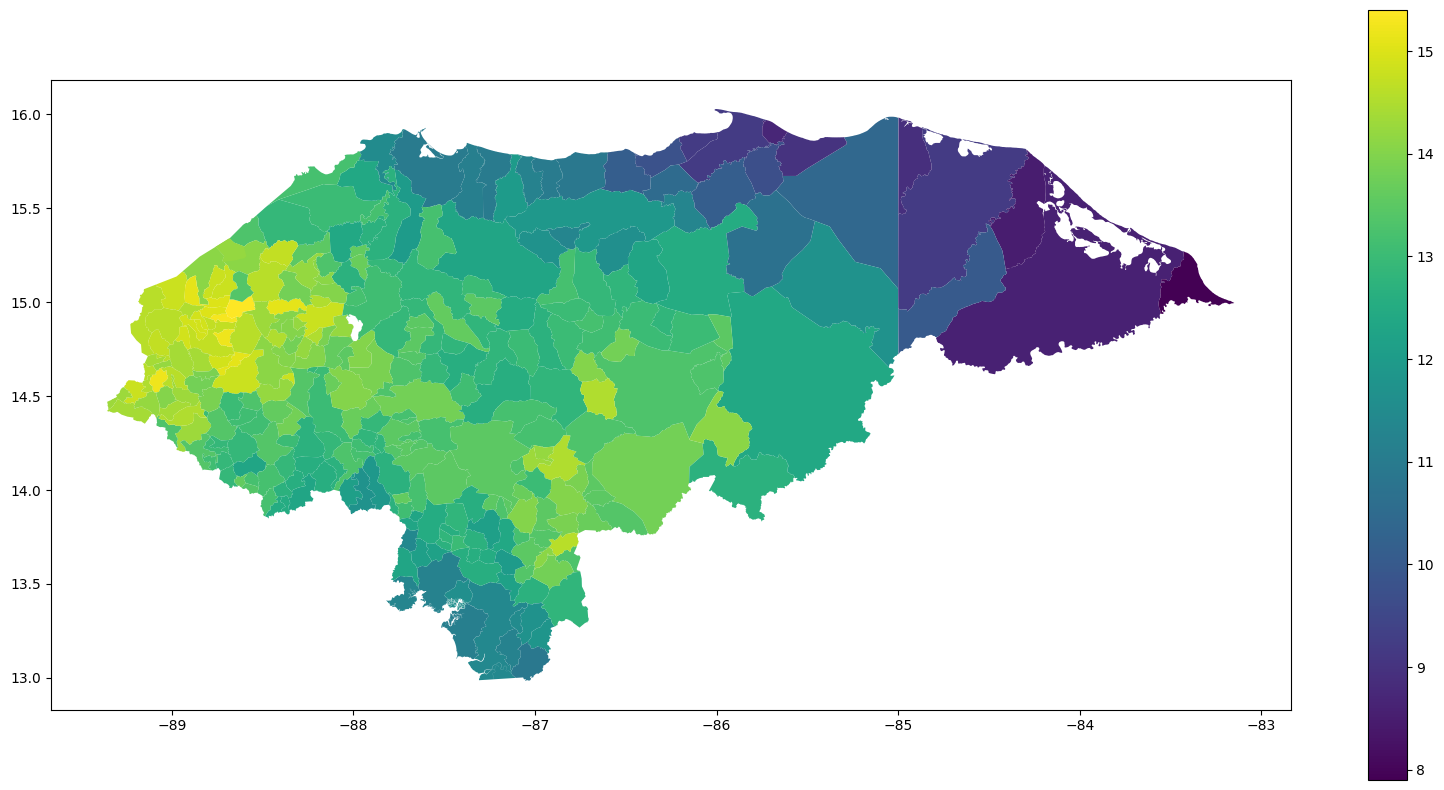

In [110]:
gdf.plot(column="pm2.5", legend=True, figsize=(20,10))

In [46]:
from math import sqrt
sqrt(gdf.AREA.mean())

301.962519613522

In [34]:
import geopandas as gpd
import pandas as pd

df = pd.read_csv(r"G:\Maestría\Tesis\Repo\data\data_out\models_by_epoch\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_val_149.csv")
val_links = df.link.drop_duplicates()

gdf = gpd.read_parquet(r"G:\Maestría\Tesis\Repo\data\data_in\ICPAG\icpag.parquet")
val_gdf = gdf[gdf.link.astype(int).isin(val_links)]
val_gdf.to_feather(r"G:\Maestría\Tesis\Repo\data\data_out\val_datasets\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_val_dataframe.feather")

In [35]:
gdf = gpd.read_parquet(r"G:\Maestría\Tesis\Repo\data\data_in\Grillas\grid_size128_tiles1.parquet")

In [36]:
gdf

id       left        top      right     bottom  \
0              1 -58.903974 -34.204721 -58.903384 -34.205311   
1              2 -58.903974 -34.205311 -58.903384 -34.205901   
2              3 -58.903974 -34.205901 -58.903384 -34.206491   
3              4 -58.903974 -34.206491 -58.903384 -34.207081   
4              5 -58.903974 -34.207081 -58.903384 -34.207671   
...          ...        ...        ...        ...        ...   
1710795  1710796 -58.128124 -34.968771 -58.127534 -34.969361   
1710796  1710797 -58.128124 -34.969361 -58.127534 -34.969951   
1710797  1710798 -58.128124 -34.969951 -58.127534 -34.970541   
1710798  1710799 -58.128124 -34.970541 -58.127534 -34.971131   
1710799  1710800 -58.128124 -34.971131 -58.127534 -34.971721   

                                                  geometry  
0        POLYGON ((-58.90397 -34.20472, -58.90397 -34.2...  
1        POLYGON ((-58.90397 -34.20531, -58.90397 -34.2...  
2        POLYGON ((-58.90397 -34.20590, -58.90397 -34.2...  
3        POLYGON ((-58.90397 -34.20649, -58.90397 -34.2...  
4        POLYGON ((-58.90397 -34.20708, -58.90397 -34.2...  
...                                                    ...  
1710795  POLYGON ((-58.12812 -34.96877, -58.12812 -34.9...  
1710796  POLYGON ((-58.12812 -34.96936, -58.12812 -34.9...  
1710797  POLYGON ((-58.12812 -34.96995, -58.12812 -34.9...  
1710798  POLYGON ((-58.12812 -34.97054, -58.12812 -34.9...  
1710799  POLYGON ((-58.12812 -34.97113, -58.12812 -34.9...  

[1710800 rows x 6 columns]

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set global variables
PROJECT = r"D:\World Bank\Paper - Child mortality and Climate Shocks"
OUTPUTS = rf"{PROJECT}\Outputs"
DATA = rf"{PROJECT}\Data"
DATA_IN = rf"{DATA}\Data_in"
DATA_PROC = rf"{DATA}\Data_proc"
DATA_OUT = rf"{DATA}\Data_out"
ERA5_DATA = rf"Z:\WB Data\ERA5 Reanalysis"

In [3]:
import xarray as xr
from climate_indices import indices, compute
from IPython.utils.capture import capture_output


precipitation = xr.open_dataset(
    rf"{DATA_PROC}\ERA5-Land_monthly_1970-2021.nc", 
)

# Define the range of values for lat and longitude
for i in [1, 3, 6, 12, 24]:
    x=0
    for x_min in tqdm(range(-180, 180, 30)):
        y=0
        for y_min in tqdm(range(-90, 90, 30), leave=False):
            with capture_output() as captured:
                prec_slice = precipitation.sel(
                    lon=slice(x_min, x_min + 30), lat=slice(y_min, y_min + 30)
                ).load()
                    
                # Filter between 1970 and 1990 to reduce size
                da_precip_groupby = prec_slice["tp"].stack(point=("lat", "lon")).groupby(group="point")

                distribution = indices.Distribution.gamma
                data_start_year = 1970
                calibration_year_initial = 1970
                calibration_year_final = 2020
                periodicity = compute.Periodicity.monthly

                da_spi = xr.apply_ufunc(
                    indices.spi,
                    da_precip_groupby,
                    i,
                    distribution,
                    data_start_year,
                    calibration_year_initial,
                    calibration_year_final,
                    periodicity,
                    dask="parallelized",
                )
                da_spi = da_spi.unstack("point").rename(f"spi{i}")
                
                encoding = {var: {"zlib": True, "complevel": 7} for var in da_spi.data_vars}
                da_spi.to_netcdf(rf"{DATA_PROC}\SPI_slices\ERA5-Land_monthly_1970-2021_slice_spi{i}_{x}_{y}.nc", encoding=encoding)
                y+=1
            x+=1

  0%|          | 0/12 [00:00<?, ?it/s]2024-08-30  15:36:16 WARNING Input contains negative values -- all negatives clipped to zero
2024-08-30  15:36:17 WARNING Input contains negative values -- all negatives clipped to zero
2024-08-30  15:36:17 WARNING Input contains negative values -- all negatives clipped to zero
  0%|          | 0/12 [01:56<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
da_spi

In [ ]:
da_spi.isel(time=7).plot()

In [ ]:
da_spi.isel(time=700).plot()

In [ ]:
!pip install climate_indices --upgrade 

In [ ]:
import climate_indices
climate_indices.indices.__version__

In [ ]:
da_spi

In [ ]:
precipitation = precipitation.load()
da_precip_groupby = precipitation["tp"].stack(point=("lat", "lon")).groupby(group="point")


In [ ]:
# Parameters
import numpy as np
import dask.array as da

distribution = indices.Distribution.gamma
data_start_year = 1970
calibration_year_initial = 1970
calibration_year_final = 1972
periodicity = compute.Periodicity.monthly

spi_path = f"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5-Land_monthly_1970-2021_SPI{i}.nc"

# Filter runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
da_spi = xr.apply_ufunc(
    indices.spi,
    da_precip_groupby,
    i,
    distribution,
    data_start_year,
    calibration_year_initial,
    calibration_year_final,
    periodicity,
    dask="parallelized",
)
da_spi = da_spi.unstack("point").rename(f"spi{i}")
# with ProgressBar():
#     encoding = {
#         var: {"zlib": True, "complevel": 5} for var in [da_spi.name]
#     }
#     da_spi.to_netcdf(
#         spi_path,
#         encoding=encoding,
#     )   

In [ ]:
with ProgressBar():
    da_spi.to_netcdf(
        spi_path,
    )   
    

In [ ]:
da_spi.isel(time=50).plot()

In [ ]:
da_spi.to_netcdf(
    spi_path,
)   

In [ ]:
da_spi

In [ ]:
da_spi.mean(dim=["lat", "lon"]).isel(time=slice(0, 500)).plot()

In [ ]:
precipitation

In [ ]:
da_spi

In [ ]:
# Select Buenos Aires
precipitation = precipitation.sel(lat=slice(-35.5, -35), lon=slice(-58.5, -58))

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)
df = pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\births_climate_4500000.parquet")

In [ ]:
import xarray as xr

ds = xr.open_dataset(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\Climate_shocks_v4.nc")

In [ ]:
sub_ds.time.values.shape

In [ ]:
# Set global variables
PROJECT = r"D:\World Bank\Paper - Child Mortality and Climate Shocks"
OUTPUTS = rf"{PROJECT}\Outputs"
DATA = rf"{PROJECT}\Data"
DATA_IN = rf"{DATA}\Data_in"
DATA_PROC = rf"{DATA}\Data_proc"
DATA_OUT = rf"{DATA}\Data_out"

### Load data #############
full_dhs = pd.read_stata(rf"{DATA_IN}/DHS/DHSBirthsGlobalAnalysis_05142024.dta")
full_dhs["ID"] = full_dhs.index
df = full_dhs.copy()


In [ ]:
    def get_climate_shock(from_date, to_date, lat, lon):
        if pd.isna(from_date):
            return np.nan

        # Filter point
        # climate_data_vars = climate_data[climate_variables]
        point_data = ds.sel(time=slice(from_date, to_date)).sel(
            lat=lat, lon=lon
        )

        # Get position of original data
        lat = point_data.lat.item()
        lon = point_data.lon.item()

        # Filter by time
        inutero_to_1st_year = point_data.isel(time=slice(0, 22))
        out = compute_stats(inutero_to_1st_year)
        # Agregar columnas acá...
        return out


In [ ]:
def compute_stats(ds):
    
    arr = ds.to_array().values
    inutero = arr[:, :9]
    born_1m = arr[:,9:11]
    born_2to12m = arr[:,11:22]

    assert inutero.shape[1] == 9, inutero.shape[1] # 9 months in utero
    assert born_1m.shape[1] == 2, born_1m.shape[1] # 1 month after birth (a little bit more because we dont have climate data for the exact day of birth. On average is one month)
    assert born_2to12m.shape[1] == 11, born_2to12m.shape[1] # next 11 months after birth
    
    # Compute stats using numpy for efficiency
    inutero = {f"{var}_inutero_mean":value for var, value in zip(ds.data_vars, np.nanmean(inutero, axis=1))}
    born_1m = {f"{var}_born_1m_mean":value for var, value in zip(ds.data_vars, np.nanmean(born_1m, axis=1))}
    born_2to12m = {f"{var}_born_2to12m_mean":value for var, value in zip(ds.data_vars, np.nanmean(born_2to12m, axis=1))}

    results = {**inutero, **born_1m, **born_2to12m}
    results = pd.Series(results)
    return results

results = compute_stats(sub_ds)
results

In [ ]:
df["day"] = 1
df["month"] = df["chb_month"].astype(float)
df["year"] = df["chb_year"].astype(float)
df["birthdate"] = pd.to_datetime(df[["year", "month", "day"]]).to_numpy()

# Maximum range of dates
df["from_date"] = df["birthdate"] + pd.DateOffset(
    months=-9
)  # From in utero (9 months before birth)
df["to_date"] = df["birthdate"] + pd.DateOffset(
    months=13
)  # To the first year of life

# Filter children from_date greater than 1990 (we only have climate data from 1990)
df = df[df["from_date"] > "1990-01-01"]

# Filter children to_date smalle than 2021 (we only have climate data to 2020)
df = df[df["to_date"] < "2021-01-01"]

df["lat_round"] = (df["LATNUM"] * 4).round() / 4
df["lon_round"] = (df["LONGNUM"] * 4).round() / 4
df = df.reset_index(drop=True)



In [ ]:
from tqdm import tqdm  # for notebooks
tqdm.pandas()

climate_results = df.head(10_000).progress_apply(
    lambda s: get_climate_shock(
        s["from_date"],
        s["to_date"],
        s["lat_round"],
        s["lon_round"],
    ),
    axis=1,
)


In [ ]:
df[df.ID == 231181]

In [ ]:
s["from_date"].item()

In [ ]:
climate_results = df[df.ID == 231181].progress_apply(
    lambda s: get_climate_shock(
        s["from_date"],
        s["to_date"],
        s["lat_round"],
        s["lon_round"],
    ),
    axis=1,
)
climate_results

In [ ]:
df[df.ID == 231181]

In [ ]:
pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\births_climate_200000.parquet")

In [ ]:
s = df.head(1)

ds.sel(lat=41.75, lon=19.75, time=slice(s["from_date"].item(), s["to_date"].item())).mean()

In [ ]:
get_climate_shock(
    s["from_date"].item(),
    s["to_date"].item(),
    s["lat_round"].item(),
    s["lon_round"].item(),
)


In [ ]:
import os
import re
import shutil

folders = os.listdir(r"D:\Datasets\ERA5 Reanalysis\monthly-land")
folders = [f for f in folders if "." not in f]

for folder in folders:
    name = folder
    print(name)
    data_file = os.listdir(rf"D:\Datasets\ERA5 Reanalysis\monthly-land\{folder}")
    source_file = rf"D:\Datasets\ERA5 Reanalysis\monthly-land\{folder}\{data_file[0]}"
    destination_file = rf"D:\Datasets\ERA5 Reanalysis\monthly-land\{name}.nc"
    
    # Copy file to monthly-land folder
    shutil.copy2(source_file, destination_file)

    
# to_names = [re.sub(r"\((\d+)\)", rf"{1970+\1}", f) for f in files] 
# to_names

In [ ]:
{f"{var}_inutero_mean":value for var, value in zip(sub_ds.data_vars, arr.mean(axis=1))}

In [ ]:
[d for d in sub_ds.data_vars]

In [ ]:
pd.DataFrame().from_dict(results)

In [ ]:
sub_ds.to_array().values.shape

In [ ]:
compute_stats(sub_ds.to_array().values)

In [ ]:
def compute_stats(data):
    return np.mean(data, axis=0), np.min(data, axis=0), np.max(data, axis=0)

results = xr.apply_ufunc(
    compute_stats,
    sub_ds,
    input_core_dims=[["time"]],
    output_core_dims=[[], [], []],
    vectorize=False,
    output_dtypes=[np.float32, np.float32, np.float32],
)

results[0].to_array().values
# np.concatenate([r.to_array() for r in result])

In [ ]:
inutero = results[0].to_array().to_dataframe(name="inutero")["inutero"]
inutero.index = [f"{i}_inutero" for i in inutero.index]
inutero
# b30d = results[1].to_array().to_dataframe(name="b30d")["b30d"]

In [ ]:
pd.read_parquet(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\births_climate_100000.parquet")

In [ ]:
result

In [ ]:
country_hurr = pd.read_stata(r"D:\World Bank\CLIENT v2\Data\Data_out\IPUMS_hurricanes_wide.dta")

In [ ]:
country_floods = pd.read_stata(r"D:\World Bank\CLIENT v2\Data\Data_out\IPUMS_floods_wide.dta")

In [ ]:
country_dr = pd.read_stata(r"D:\World Bank\CLIENT v2\Data\Data_out\IPUMS_drought_wide.dta")

In [ ]:
ids = gpd.read_feather("D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_IDs.feather")


In [ ]:
country_dr[country_dr.cntry_code.isna()]

In [ ]:
chunk = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\IPUMS\IPUMS_drought_SPEI24_25sd_1985_14_zonal_stats.parquet")

In [ ]:
chunk[chunk.index == 9826]

In [ ]:
ids = gpd.read_feather("D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_IDs.feather")
ids

In [ ]:
country_floods[(country_floods.cntry_code==275)]

In [ ]:
country_floods[(country_floods.cntry_code==275) & (country_floods.geolevel1==275045)]

In [ ]:
df = pd.read_parquet(r"D:\World Bank\CLIENT v2\Data\Data_proc\shocks_by_adm\IPUMS\out_floods_ungrouped.parquet")
df[df.ID == 4295]

In [ ]:
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\IPUMS_country_grid.nc")

# 33.411341,29.633207,36.807021,33.532308
ds.sel(y=slice(33.532308,29.633207), x=slice(35,36)).ID.plot()          

In [ ]:
country_floods[country_floods.year.isna()]

In [ ]:
ids[ids.geometry.intersects(ids[ids.ID == 10320].geometry.values[0])].explore()

In [ ]:
ids[ids.ID == 10320]

In [ ]:
ids[ids.ID == 10320].explore()

In [ ]:
import geopandas as gpd
import pandas as pd
df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_out\IPUMS_hurricanes_long.csv")

In [ ]:
df[df.CNTRY_CODE == 275]

In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\ERA5_yearly_1970-2021_SPI-SPEI.nc")

In [ ]:
ds

# 35.112151,31.692255,35.288665,31.892901
ds.sel(year=1990, x=slice(35, 36), y=slice(32, 31))["SPI-1"].plot()

In [ ]:
import folium

col = gpd.read_file(r"D:\World Bank\CLIENT v2\Data\Data_raw\IPUMS Fixed\geo1_co1964_2005.shp")
m = col.set_crs("epsg:4326").explore()

# gdf = gpd.read_file(r"C:\Users\ofici\Downloads\geo2_co1973_2005\geo2_co1973_2005\geo2_co1973_2005.shp")
# m = gdf.explore(m=m)
# add layer selection
folium.LayerControl().add_to(m)  # use folium to add layer control
m

In [ ]:
col

In [ ]:
import xarray as xr

ds = xr.open_dataset(r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5_monthly_1970-2021.nc")

In [ ]:
precipitation.sel(lat=slice(-25, -20), lon=slice(-65, -60)).isel(time=30)["t2m"].plot()

In [ ]:
precipitation = xr.open_dataset(
    r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5_monthly_1970-2021.nc", chunks={"lat":721//2+1, "lon":1440//2}
)
precipitation

In [ ]:
from climate_indices import indices, compute
import xarray as xr
import warnings
import os

# Disable runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

precipitation = xr.open_dataset(
    r"D:\World Bank\Paper - Child Mortality and Climate Shocks\Data\Data_proc\ERA5_monthly_1970-2021.nc", chunks={"lat":1000, "lon":1000}
)

# Select Argentina
# precipitation = precipitation.sel(lat=slice(-25, -20), lon=slice(-65, -60))

########################
####   Compute SPI  ####
########################

### Running this takes... A lot. Aprox. 90m for each SPI, so ~7.5h for all SPIs.

## Script based on: https://github.com/monocongo/climate_indices/issues/326
## Original paper: https://www.droughtmanagement.info/literature/AMS_Relationship_Drought_Frequency_Duration_Time_Scales_1993.pdf
## User guide to SPI: https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1208&context=droughtfacpub
#   It is recommended to use SPI-9 or SPI-12 to compute droughts.
#   "SPI values below -1.5 for these timescales (SPI-9) are usually a good indication that dryness is having a significant impact on
#    agriculture and may be affecting other sectors as well."
## More here: https://www.researchgate.net/profile/Sorin-Cheval/publication/264467702_Spatiotemporal_variability_of_the_meteorological_drought_in_Romania_using_the_Standardized_Precipitation_Index_SPI/links/5842d18a08ae2d21756372f8/Spatiotemporal-variability-of-the-meteorological-drought-in-Romania-using-the-Standardized-Precipitation-Index-SPI.pdf
## Ignore negative values, they are normal: https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ

print("Data Ready! Computing SPI. This will take at least a few hours...")

# Mask data
print(precipitation)
da_precip_groupby = precipitation["tp"].stack(point=("lat", "lon")).groupby("point")

# Parameters
distribution = indices.Distribution.gamma
data_start_year = 1970
calibration_year_initial = 1970
calibration_year_final = 2020
periodicity = compute.Periodicity.monthly

# apply SPI to each `point`
spis = []
for i in [1, 3, 6, 9, 12]:
    print(f"Computing SPI-{i}")
    da_spi = xr.apply_ufunc(
        indices.spi,
        da_precip_groupby,
        i,
        distribution,
        data_start_year,
        calibration_year_initial,
        calibration_year_final,
        periodicity,
        dask="parallelized",
    )
    da_spi = da_spi.unstack("point").rename(f"spi{i}")
    break



In [ ]:
da_spi

In [ ]:
import pandas as pd

df = pd.read_csv(r"D:\World Bank\CLIENT v2\Data\Data_out\WB_drought_long.csv")
df

In [ ]:
da_spi.to_netcdf("test.nc")

In [ ]:
da_precip_groupby

In [ ]:
da_spi = xr.apply_ufunc(
    indices.spi,
    da_precip_groupby,
    3,
    distribution,
    data_start_year,
    calibration_year_initial,
    calibration_year_final,
    periodicity,
    dask="allowed",
)


In [ ]:
da_spi

In [ ]:
df = df.dropna(subset=["v008", "chb_year", "chb_month"], how="any")

# Date of interview
df["year"] = 1900+(df["v008"]-1)//12
df["month"] = df["v008"]-12*(df["year"]-1900)
df["day"] = 1
df["interview_date"]  = pd.to_datetime(df[["year", "month", "day"]], dayfirst=False)
df["interview_month"] = df["month"]
df["interview_day"]   = df["day"]
df = df.drop(columns=["year", "month", "day"])

# Date of birth
df["year"] = df["chb_year"].astype(int)
df["month"] = df["chb_month"].astype(int)
df["day"] = 15
df["birth_date"]  = pd.to_datetime(df[["year", "month", "day"]], dayfirst=False)
df = df.drop(columns=["year", "month", "day"])

# Number of days from interview
df["days_from_interview"] = df["interview_date"] - df["birth_date"]

# excluir del análisis a aquellos niños que nacieron 12 meses alrededor de la fecha de la encuesta y no más allá de 10 y 15 años del momento de la encuesta. 
# PREGUNTA PARA PAULA: ¿ella ya hizo el filtro de 15 años y 30 dias?
df["last_15_years"] = (df["days_from_interview"] > np.timedelta64(30, 'D')) & (df["days_from_interview"] < np.timedelta64(15*365, 'D'))
df["last_10_years"] = (df["days_from_interview"] > np.timedelta64(30, 'D')) & (df["days_from_interview"] < np.timedelta64(10*365, 'D'))
df["since_2003"] = (df["interview_year"]>=2003)
df = df[df["last_15_years"] == True]

In [ ]:
df["interview_year"]

In [ ]:
df

In [ ]:
df[["year", "month", "day"]]

In [ ]:
gen interview_year = v007
gen interview_month = v008-12*(interview_year-1900)

In [ ]:
files = os.listdir(ERA5_DATA)
datasets = []
for file in tqdm(files):
    ds = xr.open_dataset(os.path.join(ERA5_DATA, file))
    datasets += [ds]
precipitation = xr.concat(datasets, dim="time")
# precipitation.to_netcdf(os.path.join(DATA_OUT, "ERA5_monthly_1970-2021.nc"))

In [ ]:
xr.open_dataset(r"Z:\Laboral\World Bank\Paper - Child mortality and Climate Shocks\Data\Data_out\Climate_shocks_v3_spi.nc")

In [ ]:
import xarray as xr

climate_data = xr.open_dataset(r"Z:\Laboral\World Bank\Paper - Child mortality and Climate Shocks\Data\Data_out\Climate_shocks_v3_spi.nc")
climate_data

In [ ]:
def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point
    point_data = climate_data.isel(time=slice(from_date, to_date)).sel(
        lat=lat, lon=lon, method="nearest"
    )

    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()

    # Filter by time
    inutero_q1 = point_data.isel(time=slice(0, 3))
    inutero_q2 = point_data.isel(time=slice(3, 6))
    inutero_q3 = point_data.isel(time=slice(6, 9))
    born_1m = point_data.isel(time=slice(9, 10))
    born_2to3m = point_data.isel(time=slice(10, 12))
    born_3to6m = point_data.isel(time=slice(12, 15))
    born_6to12m = point_data.isel(time=slice(15, 21))

    out_vars = [
        lat,
        lon,
    ]
    for spi in [
        "spi1",
        "spi3",
        "spi6",
        "spi9",
        "spi12",
    ]:
        # Compute mean values for SPI
        inutero_q1_mean = inutero_q1[spi].mean().item()
        inutero_q2_mean = inutero_q2[spi].mean().item()
        inutero_q3_mean = inutero_q3[spi].mean().item()
        born_1m_mean = born_1m[spi].mean().item()
        born_2to3m_mean = born_2to3m[spi].mean().item()
        born_3to6m_mean = born_3to6m[spi].mean().item()
        born_6to12m_mean = born_6to12m[spi].mean().item()

        out_vars_this_spi = [
            inutero_q1_mean,
            inutero_q2_mean,
            inutero_q3_mean,
            born_1m_mean,
            born_2to3m_mean,
            born_3to6m_mean,
            born_6to12m_mean,
        ]
        out_vars += out_vars_this_spi

    # Compute mean values for temperature
    inutero_q1_temp_mean = inutero_q1["t2m"].mean().item()
    inutero_q2_temp_mean = inutero_q2["t2m"].mean().item()
    inutero_q3_temp_mean = inutero_q3["t2m"].mean().item()
    born_1m_temp_mean = born_1m["t2m"].mean().item()
    born_2to3m_temp_mean = born_2to3m["t2m"].mean().item()
    born_3to6m_temp_mean = born_3to6m["t2m"].mean().item()
    born_6to12m_temp_mean = born_6to12m["t2m"].mean().item()

    out_vars_temp = [
        inutero_q1_temp_mean,
        inutero_q2_temp_mean,
        inutero_q3_temp_mean,
        born_1m_temp_mean,
        born_2to3m_temp_mean,
        born_3to6m_temp_mean,
        born_6to12m_temp_mean,
    ]
    out_vars += out_vars_temp

    return out_vars


In [ ]:
def get_climate_shock2(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan

    # Filter point
    point_data = climate_data.isel(time=slice(from_date, to_date)).sel(
        lat=lat, lon=lon, method="nearest"
    )

    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()

    # Filter by time
    inutero_q1 = point_data.isel(time=slice(0, 3))
    inutero_q2 = point_data.isel(time=slice(3, 6))
    inutero_q3 = point_data.isel(time=slice(6, 9))
    born_1m = point_data.isel(time=slice(9, 10))
    born_2to3m = point_data.isel(time=slice(10, 12))
    born_3to6m = point_data.isel(time=slice(12, 15))
    born_6to12m = point_data.isel(time=slice(15, 21))

    out_vars = [
        lat,
        lon,
    ]
    # Compute mean values for SPI
    inutero_q1_mean = inutero_q1.mean()
    inutero_q2_mean = inutero_q2.mean()
    inutero_q3_mean = inutero_q3.mean()
    born_1m_mean = born_1m.mean()
    born_2to3m_mean = born_2to3m.mean()
    born_3to6m_mean = born_3to6m.mean()
    born_6to12m_mean = born_6to12m.mean()

    return out_vars


In [ ]:
xr.open_dataset(r"Z:\Downloads\wbgt_daily_mean_2000_2021\wbgtmean_2000_daily_ERA5.nc")

In [ ]:
%%timeit -n 1000
ds.sel(lat=0, lon=-50).isel(time=20).mean()

In [ ]:
%%timeit
selection = ds.sel(lat=0, lon=-50).isel(time=20)
for spi in ["spi1", "spi3", "spi6", "spi9", "spi12", "t2m"]:
    value = selection[spi].mean().item()

In [ ]:
from metpy.calc import wet_bulb_temperature
from metpy.units import units
# wet_bulb_temperature(993 * units.hPa, 32 * units.degC, 15 * units.degC)
test = precipitation.isel(time=0, longitude=slice(0, 10), latitude=slice(0, 10))
wet_bulb_temperature(test.sp * units.Pa, test.t2m * units.degK, test.d2m * units.degK)

## Function to assign climate shocks from a date and a point

In [ ]:
climate_data = xr.open_dataset(rf"{DATA_OUT}/Climate_shocks_v2_previous_months.nc")
dates = climate_data.time.values

In [ ]:
def get_climate_shock(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan
    
    # Filter point    
    point_data = climate_data.sel(time=slice(from_date, to_date)).sel(lat=lat, lon=lon, method='nearest')
    
    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()

    # Filter by time
    inutero_q1   = point_data.isel(time=slice(0,3))
    inutero_q2   = point_data.isel(time=slice(3,6))
    inutero_q3   = point_data.isel(time=slice(6,9))
    born_1m      = point_data.isel(time=slice(9,10))
    born_2to3m  = point_data.isel(time=slice(10,12))
    born_3to6m  = point_data.isel(time=slice(12,15))
    born_6to12m  = point_data.isel(time=slice(15,21))

    out_vars = [lat, lon, ]
    for prec in ["standarized_precipitation", "standarized_precipitation_3", "standarized_precipitation_6", "standarized_precipitation_12"]:
        # Compute min and max values for both variables
        inutero_q1_mean   = inutero_q1[prec].mean().item()
        inutero_q2_mean   = inutero_q2[prec].mean().item()
        inutero_q3_mean   = inutero_q3[prec].mean().item()
        born_1m_mean      = born_1m[prec].mean().item()
        born_2to3m_mean  = born_2to3m[prec].mean().item()
        born_3to6m_mean  = born_3to6m[prec].mean().item()
        born_6to12m_mean  = born_6to12m[prec].mean().item()

        out_vars_this_prec = [inutero_q1_mean, inutero_q2_mean, inutero_q3_mean, born_1m_mean, born_2to3m_mean, born_3to6m_mean, born_6to12m_mean]
        out_vars += out_vars_this_prec

    return out_vars    


In [ ]:
def get_climate_shock_old(from_date, to_date, lat, lon):
    if pd.isna(from_date):
        return np.nan
    
    # Filter point    
    point_data = climate_data.sel(time=slice(from_date, to_date)).sel(lat=lat, lon=lon, method='nearest')
    
    # Get max and min values for standarized precipitation
    max_prec = point_data["standarized_precipitation"].max().item()
    min_prec = point_data["standarized_precipitation"].min().item()
    max_prec_m = point_data["standarized_precipitation_m"].max().item()
    min_prec_m = point_data["standarized_precipitation_m"].min().item()
    
    # Get position of original data
    lat = point_data.lat.item()
    lon = point_data.lon.item()
    
    return lat, lon, max_prec, min_prec, max_prec_m, min_prec_m

In [ ]:
climate_data.isel(time=slice(100, 110), lat=-50, lon=120)["standarized_precipitation"].mean().item()

In [ ]:
%load_ext line_profiler
def get_climate_shock_prof():
    date = np.random.choice(dates[12:-12])
    from_date, to_date = date + pd.DateOffset(months=-9), date + pd.DateOffset(years=1)
    lat, lon = np.random.uniform(-90, 90), np.random.uniform(-180, 180)
    
    get_climate_shock(from_date, to_date, lat, lon)    
    return

In [ ]:
%lprun -f get_climate_shock_prof get_climate_shock_prof()

In [ ]:
%timeit get_climate_shock_prof()

## Open DHS data and add the shock data to the dataframe

In [ ]:
df = pd.read_stata(rf"{DATA_IN}/DHS/DHSBirthsGlobalAnalysis_04172024.dta")
df['ID'] = df.index

### Create dates variables:
We considered a 

In [ ]:
# Create datetime object from year and month
df["day"] = 1
df["month"] = df["chb_month"].astype(float)
df["year"] = df["chb_year"].astype(float)
df["birthdate"] = pd.to_datetime(df[["year", "month","day"]]).to_numpy()

# Maximum range of dates
df["from_date"] = df["birthdate"] + pd.DateOffset(months=-9) # From in utero (9 months before birth) 
df["to_date"] = df["birthdate"] + pd.DateOffset(years=1) # To the first year of life

# Filter children from_date greater than 1990 (we only have climate data from 1990)
df = df[df["from_date"] > "1990-01-01"]

# # Construct deathdate variable
# df["deathdate"] = df[df["child_agedeath"]<=12].progress_apply(lambda x: x["birthdate"] + pd.DateOffset(months=x["child_agedeath"]), axis=1)

# # Replace to_date with deathdate if the child died
# df["to_date"] = np.where((df["child_agedeath"]<=12) & (df["deathdate"]<df["to_date"]), df["deathdate"], df["to_date"])

# Filter children to_date smalle than 2021 (we only have climate data to 2020)
df = df[df["to_date"] < "2021-01-01"]

In [ ]:
coords_cols = ["lat_climate", "lon_climate"]
prec_cols = ["prec_inutero_q1", "prec_inutero_q2", "prec_inutero_q3", "prec_born_1m", "prec_born_2to3m", "prec_born_3to6m", "prec_born_6to12m"]
prec_3_cols = ["prec_3_inutero_q1", "prec_3_inutero_q2", "prec_3_inutero_q3", "prec_3_born_1m", "prec_3_born_2to3m", "prec_3_born_3to6m", "prec_3_born_6to12m"]
prec_6_cols = ["prec_6_inutero_q1", "prec_6_inutero_q2", "prec_6_inutero_q3", "prec_6_born_1m", "prec_6_born_2to3m", "prec_6_born_3to6m", "prec_6_born_6to12m"]
prec_12_cols = ["prec_12_inutero_q1", "prec_12_inutero_q2", "prec_12_inutero_q3", "prec_12_born_1m", "prec_12_born_2to3m", "prec_12_born_3to6m", "prec_12_born_6to12m"]
all_cols = coords_cols + prec_cols + prec_3_cols + prec_6_cols + prec_12_cols

for n in tqdm(range(0, df.ID.max(), 10_000)):
    if os.path.exists(rf"{DATA_PROC}/births_climate_{n}.csv"):
        print(f"births_climate_{n}.csv exists, moving to next iteration")
        continue
    chunk = df.loc[(df.ID >= n) & (df.ID < n+10_000), ['ID', 'from_date', 'to_date', 'LATNUM', 'LONGNUM']].copy()
    if chunk.shape[0]==0:
        continue
    climate_results = chunk[['from_date', 'to_date', 'LATNUM', 'LONGNUM']].apply(lambda s: get_climate_shock(s['from_date'], s['to_date'], s['LATNUM'], s['LONGNUM']), axis=1)
    climate_results = climate_results.apply(pd.Series)
    climate_results.columns = all_cols
    climate_results["ID"] = chunk["ID"]
    climate_results.to_csv(rf"{DATA_PROC}/births_climate_{n}.csv")
    
# df[all_cols] = climate_data

In [ ]:
# # For debugging
# chunk[['from_date', 'to_date', 'LATNUM', 'LONGNUM']].progress_apply(lambda s: get_climate_shock(s['from_date'], s['to_date'], s['LATNUM'], s['LONGNUM']), axis=1)

In [ ]:
files = os.listdir(rf"{DATA_PROC}") 
files = [f for f in files if f.startswith("births_climate_")]
data = []
for file in tqdm(files):
    df = pd.read_csv(rf"{DATA_PROC}/{file}")
    data += [df]
df = pd.concat(data)

In [ ]:
df = df.drop(columns="Unnamed: 0")
df.to_stata(rf"{DATA_PROC}\ClimateShocks_assigned.dta")

# Example Plots

In [ ]:
import matplotlib.pyplot as plt
pos = np.random.randint(0, 500000)
pos = 428380      
filtered2 = climate_data.standarized_precipitation.sel(lat=df.at[pos, "LATNUM"], lon=df.at[pos, "LONGNUM"], method="nearest")
filtered2.plot(figsize=(12, 2))

plt.axhline(2, color="red")
plt.axhline(-2, color="red")



In [ ]:
climate

In [ ]:
import gc
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

climate = pd.read_stata(rf"{DATA_PROC}\ClimateShocks_assigned.dta")

dhs = pd.read_stata(rf"{DATA_IN}/DHS/DHSBirthsGlobalAnalysis_04172024.dta")
dhs["ID"] = dhs.index

merged = dhs.merge(climate, on="ID")
dhs = 0
climate = 0


In [ ]:
# merged = merged.head(10_000)
merged["lon_climate_2"] = merged["lon_climate"].round(0) 
merged["lon_climate_3"] = merged["lon_climate_2"] - merged["lon_climate_2"].astype(int) % 2 
merged["lat_climate_2"] = merged["lat_climate"].round(0)
merged["lat_climate_3"] = merged["lat_climate_2"] - merged["lat_climate_2"].astype(int) % 2 

merged["ID_cell3"] = merged["lon_climate_3"].astype(str) + "_" + merged["lat_climate_3"].astype(str)
one_hot = pd.get_dummies(merged["ID_cell3"], prefix='ID_cell3')
years_interaction = one_hot.multiply(merged["chb_year"], axis="index")
years_interaction.columns = [f"years_{col}" for col in years_interaction.columns]
months_interaction = one_hot.multiply(merged["chb_year"], axis="index")
months_interaction.columns = [f"months_{col}" for col in months_interaction.columns]
gc.collect()

merged[one_hot.columns] = one_hot
merged[years_interaction.columns] = years_interaction
merged[months_interaction.columns] = months_interaction
gc.collect()

In [ ]:
merged[one_hot.columns] = one_hot
merged[years_interaction.columns] = years_interaction
merged[months_interaction.columns] = months_interaction

In [ ]:
pd.concat([merged, one_hot])

In [ ]:
one_hot.memory_usage().sum() * 1e-9

In [ ]:
import pandas as pd
df = pd.read_stata(rf"{DATA_OUT}\DHSBirthsGlobal&ClimateShocks.dta")

In [ ]:
!py -m pip install fastparquet

In [ ]:
df.to_csv(rf"{DATA_OUT}\DHSBirthsGlobal&ClimateShocks.csv")

In [ ]:
import pandas as pd
pd.read_excel(r"Z:\Downloads\serie2016.xls")

In [ ]:
import pandas as pd
import geopandas as gpd

df = pd.read_parquet(r"G:\Maestría\Tesis\Repo\data\data_out\gridded_predictions\mobnet_v3_large_size128_tiles1_sample1\mobnet_v3_large_size128_tiles1_sample1_496_predictions.parquet")
test = gpd.read_feather(r"G:\Maestría\Tesis\Repo\data\data_out\test_datasets\mobnet_v3_large_size128_tiles1_sample1_aug_test_dataframe.feather")

In [ ]:
df = df.merge(test, on="link")
df = df[df.prediction!=0.45116878] # Remove black predictions

In [ ]:
import seaborn as sns
data = df.groupby("link")[["real_value", "prediction"]].mean()

data = data.reset_index()

In [ ]:
def plot_predictions_vs_real(
    best_case,
):
    import plotly.express as px
    from plotly import graph_objects as go

    axis_range = [-2.2, 2.2]

    import seaborn as sns

    fig = px.scatter(
        best_case, x="real_value", y="prediction", hover_data=["link"]
    )
    
    fig.update_yaxes(range=axis_range, title="Predicción Media del Radio Censal (estandarizada)", title_font=dict(size=18)) 
    fig.update_xaxes(range=axis_range, title="Ingreso Medio del Radio Censal (estandarizado)",title_font=dict(size=18))
    fig.update_layout(
        autosize=False,
        width=800,
        height=700,
    )

    # Add 45° line
    line_fig = go.Figure(
        data=go.Scatter(
            x=best_case["real_value"],
            y=best_case["real_value"],
            mode="lines",
            name="45°",
        )
    )
    fig.add_trace(line_fig.data[0])
    fig.update_traces(marker=dict(size=5))
    # Reduce margin
    fig.update_layout(margin=dict(l=2, r=2, b=2, t=2))

    return fig

fig = plot_predictions_vs_real(
    data,
)

# Exoport as png
fig.write_image(r"G:\Maestría\Tesis\Repo\outputs\mobnet_v3_large_size128_tiles1_sample1_aug\mobnet_v3_large_size128_tiles1_sample1_aug.png", scale=4)

In [ ]:
fig.show()

In [ ]:
data["error"] = data["real_value"] - data["prediction"]
ss_res = (data["error"] ** 2).sum()  # Sum of squared residuals
ss_tot = ((data["real_value"] - data["real_value"].mean()) ** 2).sum()  # Total sum of squares
r2 = 1 - ss_res / ss_tot
r2


In [ ]:
df2 = pd.read_parquet(r"G:\Maestría\Tesis\Repo\data\data_out\gridded_predictions\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_141_predictions_2013.parquet")

In [ ]:
import seaborn as sns
data2 = df2.groupby("link")[["real_value", "prediction"]].mean()

data2 = data2.reset_index()

In [ ]:
plot_predictions_vs_real(
    data2,
)